# Supervised Learning — Model Quality

## 📌 Project Goal
Build a model that predicts the probability of a **decrease in a customer’s activity** and identify segments for personalized marketing offers.
GitHub repository: https://github.com/alexkeram/mini-etl-dbt-prefect

---

## 🔹 Step 1. Data Loading

- Load all provided files:
  - `market_file.csv`
  - `market_money.csv`
  - `market_time.csv`
  - `money.csv`
- Verify that the data matches the documentation.
- Double-check delimiters and numeric parsing (notably `sep=';'` and `decimal=','`).

---

## 🔹 Step 2. Data Preprocessing

- Inspect dtypes, missing values, and duplicates.
- Convert numeric features to proper numeric types (e.g., `object → float`).
- Drop or impute missing values where appropriate.
- Perform initial cleaning and recode categorical values if needed.

---

## 🔹 Step 3. Exploratory Data Analysis (EDA)

- Visualize and describe features:
  - distributions,
  - outliers,
  - unique values for categorical features.
- Identify customers with at least one purchase in the last 3 months.
- Examine the distribution of the target (`customer_activity`, focusing on the class “decreased”).
- Detect potential correlations and anomalies.

---

## 🔹 Step 4. Merging Tables

- Join tables by `id`, reshaping the period tables to a **wide** format:
  - From `market_money.csv` build: `revenue_current`, `revenue_prev`, `revenue_prev_prev`.
  - From `market_time.csv` build: `time_current`, `time_prev`, `time_prev_prev`.
- Join these to `market_file.csv`.
- Keep `money.csv` (profit) separate for later segmentation.

---

## 🔹 Step 5. Correlation Analysis

- Compute a correlation matrix for numeric features.
- Visualize a heatmap.
- If necessary, remove one of the strongly correlated features (to mitigate multicollinearity).

---

## 🔹 Step 6. Modeling with Pipelines

### 6.1 Pipeline Preparation

- Use `ColumnTransformer` for separate preprocessing:
  - Categorical: `OneHotEncoder` (or `OrdinalEncoder` where order is known).
  - Numeric: `StandardScaler` (or `MinMaxScaler` as needed).
- Assemble the end-to-end workflow with `Pipeline`.

### 6.2 Model Training

Train and tune the following models:
- `LogisticRegression`
- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `SVC`

### 6.3 Metric Selection

- Primary metric: **ROC AUC** (binary classification with potential class imbalance).
- Use `RandomizedSearchCV` or `GridSearchCV` with cross-validation.

---

## 🔹 Step 7. Model Interpretation

- Select the best model by ROC AUC.
- Estimate feature importance for the winner.
- Use `SHAP` to visualize global/individual feature effects.
- Summarize:
  - which features have the largest impact;
  - which ones can be dropped;
  - business interpretation of the results.

---

## 🔹 Step 8. Customer Segmentation & Recommendations

### 8.1 Segmentation

- Combine model outputs (probability of **decreased** activity) with `money.csv`.
- Create 2–3 segments by:
  - profit,
  - share of promo purchases,
  - product category,
  - probability of decreased activity.

### 8.2 Segment Analysis

- Visualize distributions and key features for the chosen segment.
- Describe business characteristics.
- Propose retention actions:
  - newsletter policy tweaks,
  - new promotions,
  - personalized offers.

### 8.3 Segment Conclusions

- Which segment is selected.
- What actions are proposed.
- Why this matters for the business.

---

## 🔹 Step 9. Overall Summary

- Briefly cover:
  - the task,
  - raw data & sources,
  - preprocessing steps,
  - model training & results,
  - the selected model & metric,
  - feature interpretation,
  - segmentation & business recommendations.


In [61]:
# Core libs
import duckdb
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import roc_auc_score

# Feature interpretation
import shap

# Warnings (mute noisy progress-bar warnings if ipywidgets is missing)
import warnings
warnings.filterwarnings("ignore")

# Optional: specifically silence tqdm's IProgress warnings in classic Jupyter
try:
    from tqdm import TqdmWarning  # type: ignore
    warnings.filterwarnings("ignore", category=TqdmWarning)
except Exception:
    pass

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True  # helpful for EDA plots

# Safe display for both Jupyter and non-Jupyter environments
try:
    from IPython.display import display
except Exception:
    def display(obj):  # noqa: D401
        """Fallback display: print head() if available."""
        try:
            print(obj.head())
        except Exception:
            print(obj)

# Data Loading

In [62]:
# Step 1. Data Loading
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)

print("Available tables:")
display(
    con.execute("""
        select table_schema, table_name
        from information_schema.tables
        where table_schema ilike 'analytics%'    -- staging/marts/analytics*
        order by 1, 2
    """).df()
)

TABLES = {
    "stg_market_file": "select * from analytics_staging.stg_market_file",
    "stg_market_money": "select * from analytics_staging.stg_market_money",
    "stg_market_time": "select * from analytics_staging.stg_market_time",
    "stg_money": "select * from analytics_staging.stg_money"
}
def peek(df: pd.DataFrame, name: str, n: int = 5):
    print(f"\n### {name}")
    print(f"shape: {df.shape}")
    print("dtypes:")
    print(df.dtypes)
    if df.select_dtypes("number").shape[1] > 0:
        print("\ndescribe (numeric):")
        display(df.describe().T)

    na = df.isna().sum()
    if (na > 0).any():
        na = na[na > 0].sort_values(ascending=False)
        print("\nmissing values (non-zero):")
        display(na.to_frame("na_count"))
    print("\nhead():")
    display(df.head(n))

frames = {}
for name, sql in TABLES.items():
    df = con.execute(sql).df()
    frames[name] = df
    peek(df, name)


Available tables:


,table_schema,table_name
0,analytics,raw_market_file
1,analytics,raw_market_money
2,analytics,raw_market_time
3,analytics,raw_money
4,analytics_marts,dim_customer
5,analytics_marts,fct_profit
6,analytics_marts,fct_revenue_clean
7,analytics_marts,fct_time
8,analytics_marts,int_ids_to_remove
9,analytics_marts,int_revenue_clean



### stg_market_file
shape: (1300, 13)
dtypes:
customer_id                    int64
customer_activity             object
service_tier                  object
allow_notifications             bool
popular_category              object
duration_days                  int32
marketing_activity_6m        float64
marketing_activity_curr_m    float64
promo_purchases              float64
avg_categories_per_visit       int32
unpaid_products_qtr            int32
service_error_flag             int32
pages_per_visit                int32
dtype: object

describe (numeric):


,count,mean,std,min,25%,50%,75%,max
customer_id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
duration_days,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
marketing_activity_6m,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
marketing_activity_curr_m,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
promo_purchases,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
avg_categories_per_visit,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
unpaid_products_qtr,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
service_error_flag,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
pages_per_visit,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00



missing values (non-zero):


,na_count
popular_category,223



head():


,customer_id,customer_activity,service_tier,allow_notifications,popular_category,duration_days,marketing_activity_6m,marketing_activity_curr_m,promo_purchases,avg_categories_per_visit,unpaid_products_qtr,service_error_flag,pages_per_visit
0,215348,decreased,premium,True,for children,121,3.4,5.0,0.00,6,2,1,5
1,215349,decreased,premium,True,for children,819,4.4,4.0,0.75,4,4,2,5
2,215350,decreased,standard,False,home textiles,539,4.9,3.0,0.14,5,2,1,5
3,215351,decreased,standard,True,for children,896,3.2,5.0,0.99,5,0,6,4
4,215352,decreased,standard,False,for children,1064,5.1,3.0,0.94,3,2,3,2



### stg_market_money
shape: (3900, 3)
dtypes:
state_id      int64
period       object
revenue     float64
dtype: object

describe (numeric):


,count,mean,std,min,25%,50%,75%,max
state_id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
revenue,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2



head():


,state_id,period,revenue
0,215348,prev_prev_month,0.0
1,215348,current_month,3293.1
2,215348,prev_month,0.0
3,215349,prev_prev_month,4472.0
4,215349,current_month,4971.6



### stg_market_time
shape: (2600, 3)
dtypes:
time_chunk_id     int64
period           object
minutes_spent     int32
dtype: object

describe (numeric):


,count,mean,std,min,25%,50%,75%,max
time_chunk_id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
minutes_spent,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0



head():


,time_chunk_id,period,minutes_spent
0,215348,current_month,14
1,215348,prev_month,13
2,215349,current_month,10
3,215349,prev_month,12
4,215350,current_month,13



### stg_money
shape: (1300, 2)
dtypes:
money_id      int64
profit      float64
dtype: object

describe (numeric):


,count,mean,std,min,25%,50%,75%,max
money_id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
profit,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43



head():


,money_id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Summary for Step 1: Data Loading

The data was loaded successfully and generally matches the specification.
All tables have the correct structure and the expected number of rows.
Minor inconsistencies in individual values (e.g., typos in category or period names) will be handled during the preprocessing and cleaning steps.
You can proceed to the next stage.


# Preprocessing Step 2


===== dim_customer =====
Shape: (1297, 13)
Duplicates (full-row): 0

Dtypes:
 customer_id                    int64
customer_activity             object
service_tier                  object
allow_notifications             bool
popular_category              object
duration_days                  int32
marketing_activity_6m        float64
marketing_activity_curr_m    float64
promo_purchases              float64
avg_categories_per_visit       int32
unpaid_products_qtr            int32
service_error_flag             int32
pages_per_visit                int32
dtype: object

Missing values (non-zero):


,na_count
popular_category,223


------------------------------------------------------------

===== fct_revenue_clean =====
Shape: (3783, 3)
Duplicates (full-row): 0

Dtypes:
 customer_id      int64
period          object
revenue        float64
dtype: object

Missing values: none
------------------------------------------------------------

===== fct_time =====
Shape: (2594, 3)
Duplicates (full-row): 0

Dtypes:
 customer_id       int64
period           object
minutes_spent     int32
dtype: object

Missing values: none
------------------------------------------------------------

===== fct_profit =====
Shape: (1297, 2)
Duplicates (full-row): 0

Dtypes:
 customer_id      int64
profit         float64
dtype: object

Missing values: none
------------------------------------------------------------

===== modeling_dataset (wide) =====
Shape: (1297, 20)
Duplicates (full-row): 0

Dtypes:
 customer_id                    int64
customer_activity             object
service_tier                  object
allow_notifications        

,na_count
minutes_prev2_m,1297
popular_category,223
revenue_curr_m,101
revenue_prev_m,7


------------------------------------------------------------
Customers with >3 revenue rows (should be 0): 0
Rows with unknown period in revenue: 0

Negative values count per numeric column (should be 0 or small):
{}


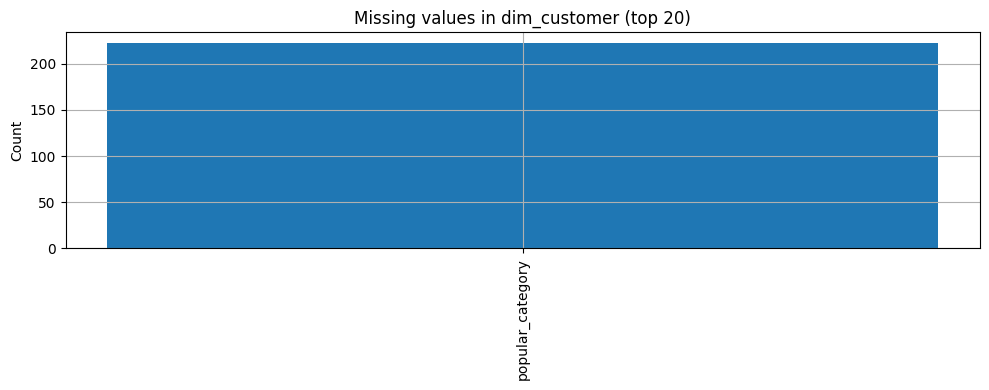

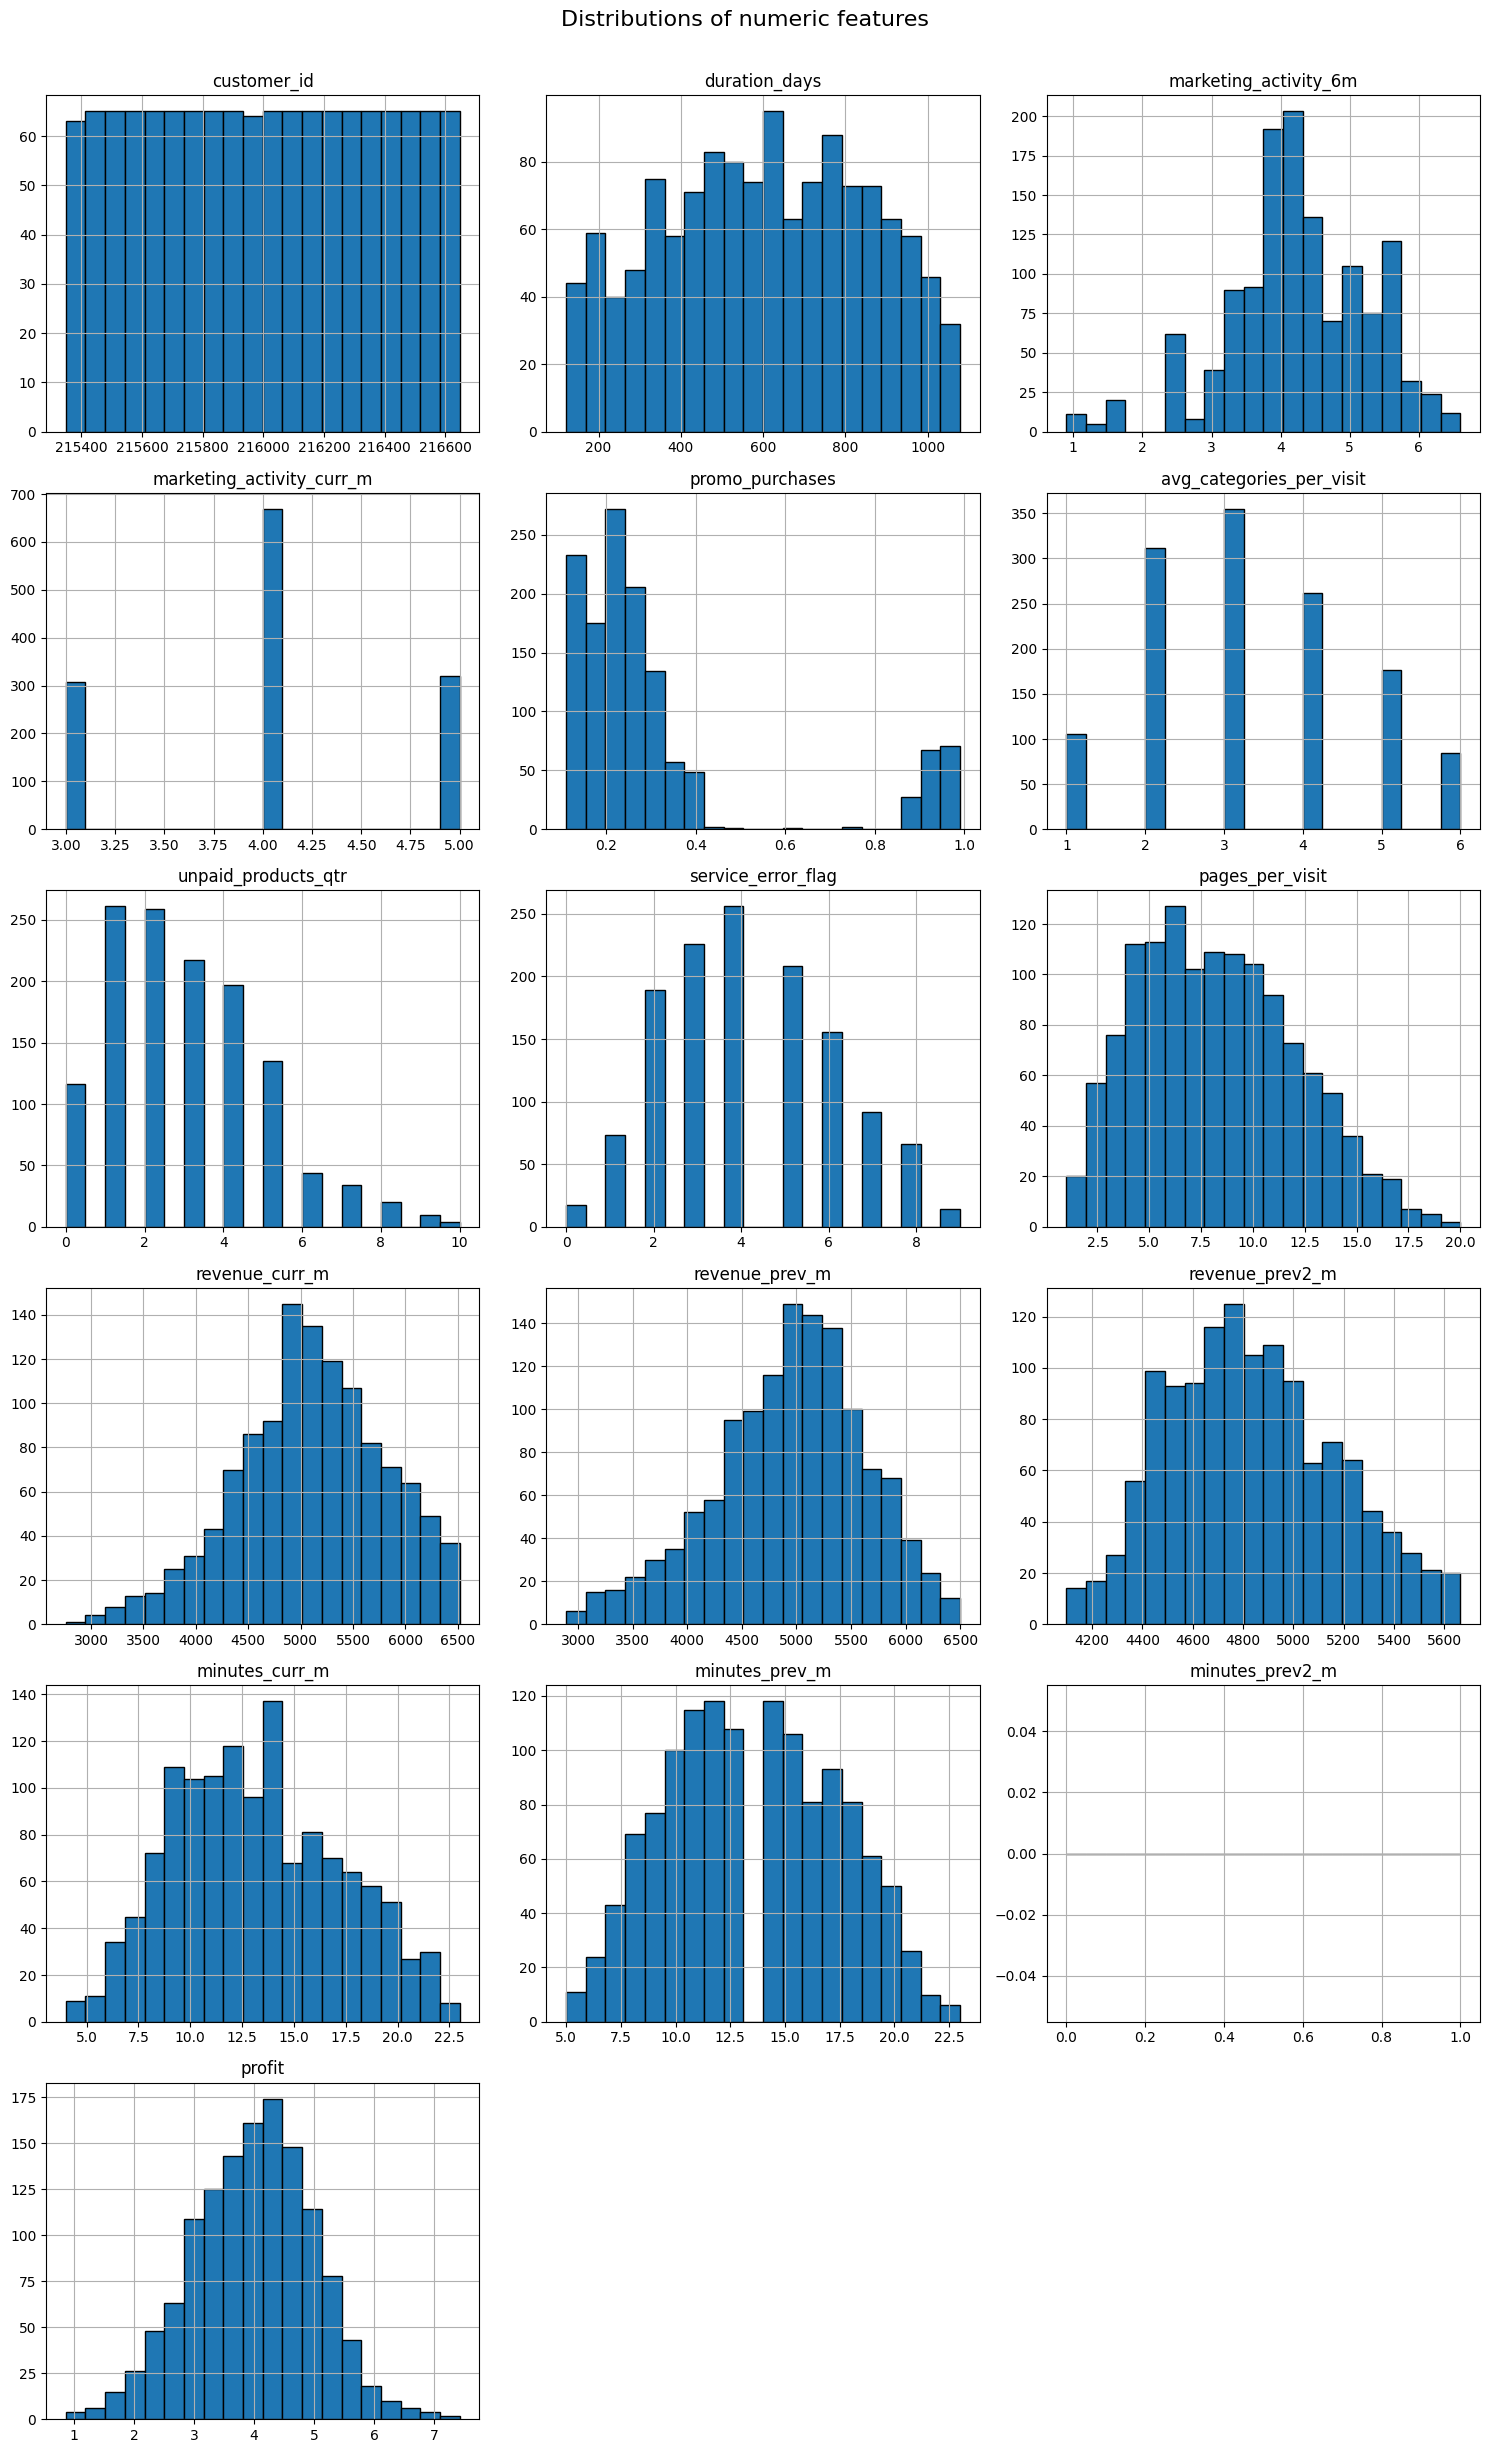

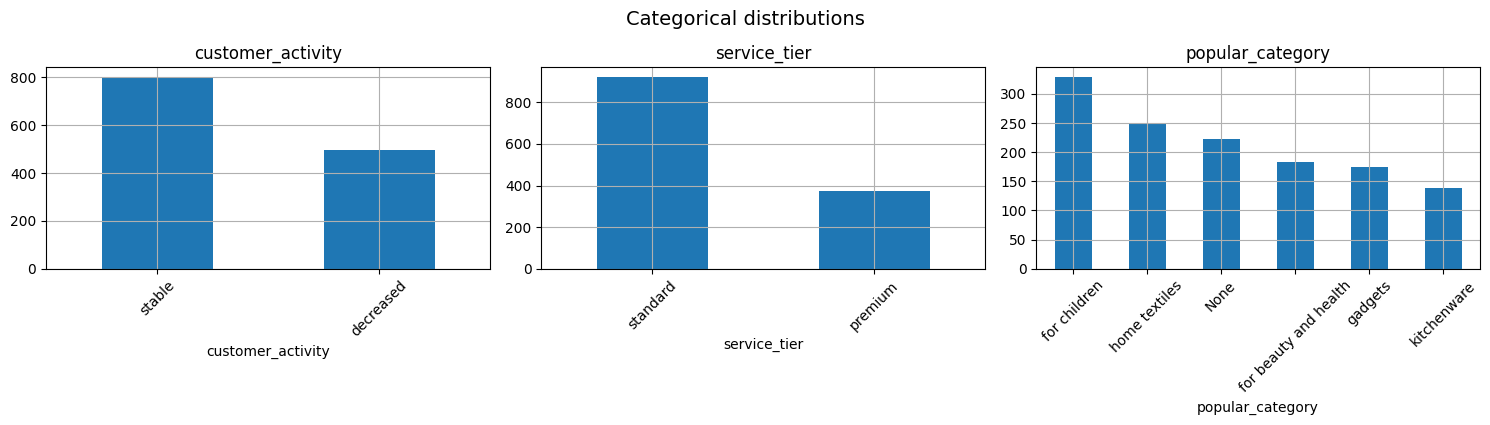


Heads:


,customer_id,customer_activity,service_tier,allow_notifications,popular_category,duration_days,marketing_activity_6m,marketing_activity_curr_m,promo_purchases,avg_categories_per_visit,unpaid_products_qtr,service_error_flag,pages_per_visit
0,215349,decreased,premium,True,for children,819,4.4,4.0,0.75,4,4,2,5
1,215350,decreased,standard,False,home textiles,539,4.9,3.0,0.14,5,2,1,5
2,215351,decreased,standard,True,for children,896,3.2,5.0,0.99,5,0,6,4
3,215352,decreased,standard,False,for children,1064,5.1,3.0,0.94,3,2,3,2
4,215353,decreased,standard,True,home textiles,762,3.3,4.0,0.26,4,1,1,4


,customer_id,period,revenue
0,215349,prev_prev_month,4472.0
1,215349,current_month,4971.6
2,215349,prev_month,5216.0
3,215350,prev_prev_month,4826.0
4,215350,current_month,5058.4


,customer_id,period,minutes_spent
0,215349,current_month,10
1,215349,prev_month,12
2,215350,current_month,13
3,215350,prev_month,8
4,215351,current_month,13


,customer_id,profit
0,215349,4.16
1,215350,3.13
2,215351,4.87
3,215352,4.21
4,215353,3.95


,customer_id,customer_activity,service_tier,allow_notifications,popular_category,duration_days,marketing_activity_6m,marketing_activity_curr_m,promo_purchases,avg_categories_per_visit,unpaid_products_qtr,service_error_flag,pages_per_visit,revenue_curr_m,revenue_prev_m,revenue_prev2_m,minutes_curr_m,minutes_prev_m,minutes_prev2_m,profit
0,215349,decreased,premium,True,for children,819,4.4,4.0,0.75,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0,NaN,4.16
1,215350,decreased,standard,False,home textiles,539,4.9,3.0,0.14,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0,NaN,3.13
2,215351,decreased,standard,True,for children,896,3.2,5.0,0.99,5,0,6,4,NaN,6158.0,4793.0,13.0,11.0,NaN,4.87
3,215352,decreased,standard,False,for children,1064,5.1,3.0,0.94,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0,NaN,4.21
4,215353,decreased,standard,True,home textiles,762,3.3,4.0,0.26,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0,NaN,3.95


In [63]:
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)

# Read curated tables from marts
dim = con.execute("select * from analytics_marts.dim_customer").df()
rev = con.execute("select * from analytics_marts.fct_revenue_clean").df()
tm = con.execute("select * from analytics_marts.fct_time").df()
pf = con.execute("select * from analytics_marts.fct_profit").df()
ds = con.execute("select * from analytics_marts.modeling_dataset").df()


# --- 1) Data passport helpers ---
def check_df(df: pd.DataFrame, name: str) -> None:
    """Print a passport for a DataFrame."""
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    print("Duplicates (full-row):", int(df.duplicated().sum()))
    print("\nDtypes:\n", df.dtypes)
    na = df.isna().sum()
    if (na > 0).any():
        print("\nMissing values (non-zero):")
        display(na[na > 0].sort_values(ascending=False).to_frame("na_count"))
    else:
        print("\nMissing values: none")
    print("-" * 60)


check_df(dim, "dim_customer")
check_df(rev, "fct_revenue_clean")
check_df(tm, "fct_time")
check_df(pf, "fct_profit")
check_df(ds, "modeling_dataset (wide)")

# --- 2) Integrity checks that replace old CSV-based logic ---

# 2.1 uniqueness of customer in dim and dataset
assert dim['customer_id'].is_unique, "dim_customer must be 1 row per customer"
assert ds['customer_id'].is_unique, "modeling_dataset must be 1 row per customer"

# 2.2 revenue rows should be <= 3 per customer (3 periods)
rev_cnt = rev.groupby('customer_id').size()
viol = rev_cnt[rev_cnt > 3]
print(f"Customers with >3 revenue rows (should be 0): {len(viol)}")

# 2.3 period domain check
bad_period = rev[~rev['period'].isin(['current_month', 'prev_month', 'prev_prev_month'])]
print(f"Rows with unknown period in revenue: {bad_period.shape[0]}")

# 2.4 non-negative numeric sanity in dataset
num_cols = ds.select_dtypes("number").columns
neg = {c: int((ds[c] < 0).sum()) for c in num_cols}
print("\nNegative values count per numeric column (should be 0 or small):")
print({k: v for k, v in neg.items() if v > 0})

# --- 3) Visuals (missingness + distributions) ---

# Missingness in dim_customer (top 20)
na_dim = dim.isna().sum().sort_values(ascending=False)
na_dim = na_dim[na_dim > 0].head(20)
if not na_dim.empty:
    plt.figure(figsize=(10, 4))
    plt.bar(na_dim.index, na_dim.values)
    plt.xticks(rotation=90)
    plt.title("Missing values in dim_customer (top 20)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Histograms for numeric features in modeling_dataset
num_cols = ds.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    cols = 3
    rows = math.ceil(len(num_cols) / cols)
    plt.figure(figsize=(5 * cols, 4 * rows))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, cols, i + 1)
        plt.hist(ds[col].dropna(), bins=20, edgecolor='black')
        plt.title(col)
        plt.tight_layout()
    plt.suptitle("Distributions of numeric features", y=1.02, fontsize=16)
    plt.show()

# Categorical distributions from dim_customer
cat_cols = ['customer_activity', 'service_tier', 'popular_category']
cat_cols = [c for c in cat_cols if c in dim.columns]
if cat_cols:
    plt.figure(figsize=(5 * len(cat_cols), 4))
    for i, col in enumerate(cat_cols):
        plt.subplot(1, len(cat_cols), i + 1)
        dim[col].value_counts(dropna=False).head(20).plot(kind='bar')
        plt.title(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.suptitle("Categorical distributions", y=1.05, fontsize=14)
    plt.show()

# --- 4) Heads for quick eyeballing ---
print("\nHeads:")
display(dim.head())
display(rev.head())
display(tm.head())
display(pf.head())
display(ds.head())


### Summary for Step 2: Data Preprocessing

- **All data cleaning and normalization steps** were successfully in the **dbt pipeline**.
- The resulting **staging** and **marts** tables have correct data types and consistent naming conventions.
- **No missing values or duplicates** were found in the core fact tables (`fct_revenue_clean`, `fct_time`, `fct_profit`).
- The integrated dataset `modeling_dataset` combines customer attributes, revenue, time, and profit — ready for modeling.
- Minor missing values remain only in a few metrics (`minutes_prev2_m`, `revenue_curr_m`, `revenue_prev_m`), which is acceptable and expected due to data coverage.
- No invalid periods or negative numeric values were detected.
- All categorical features (`customer_activity`, `service_tier`, `popular_category`) show clean, interpretable distributions.
- Outliers in revenue were filtered out using the IQR rule inside dbt, ensuring stable numeric ranges.
- Overall, the dataset is **clean, consistent, and ready for EDA and modeling**.


# EDA

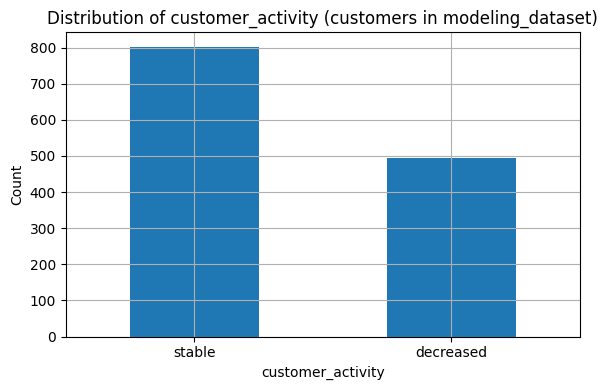

customer_activity
stable       61.84
decreased    38.16
Name: proportion, dtype: float64


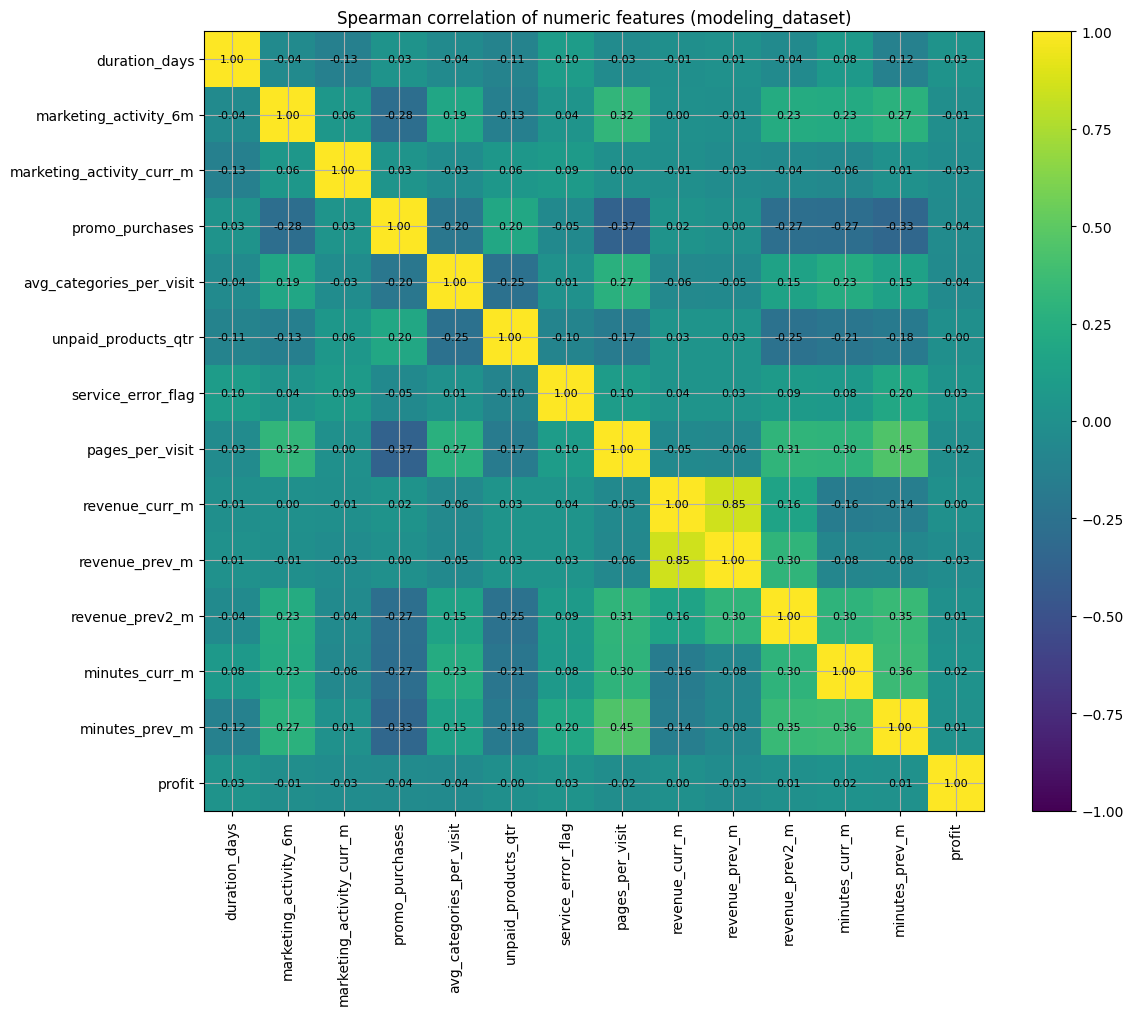


Outliers per feature (IQR rule):
duration_days: 0
marketing_activity_6m: 36
marketing_activity_curr_m: 0
promo_purchases: 168
avg_categories_per_visit: 0
unpaid_products_qtr: 14
service_error_flag: 0
pages_per_visit: 0
revenue_curr_m: 9
revenue_prev_m: 13
revenue_prev2_m: 0
minutes_curr_m: 0
minutes_prev_m: 0
profit: 11


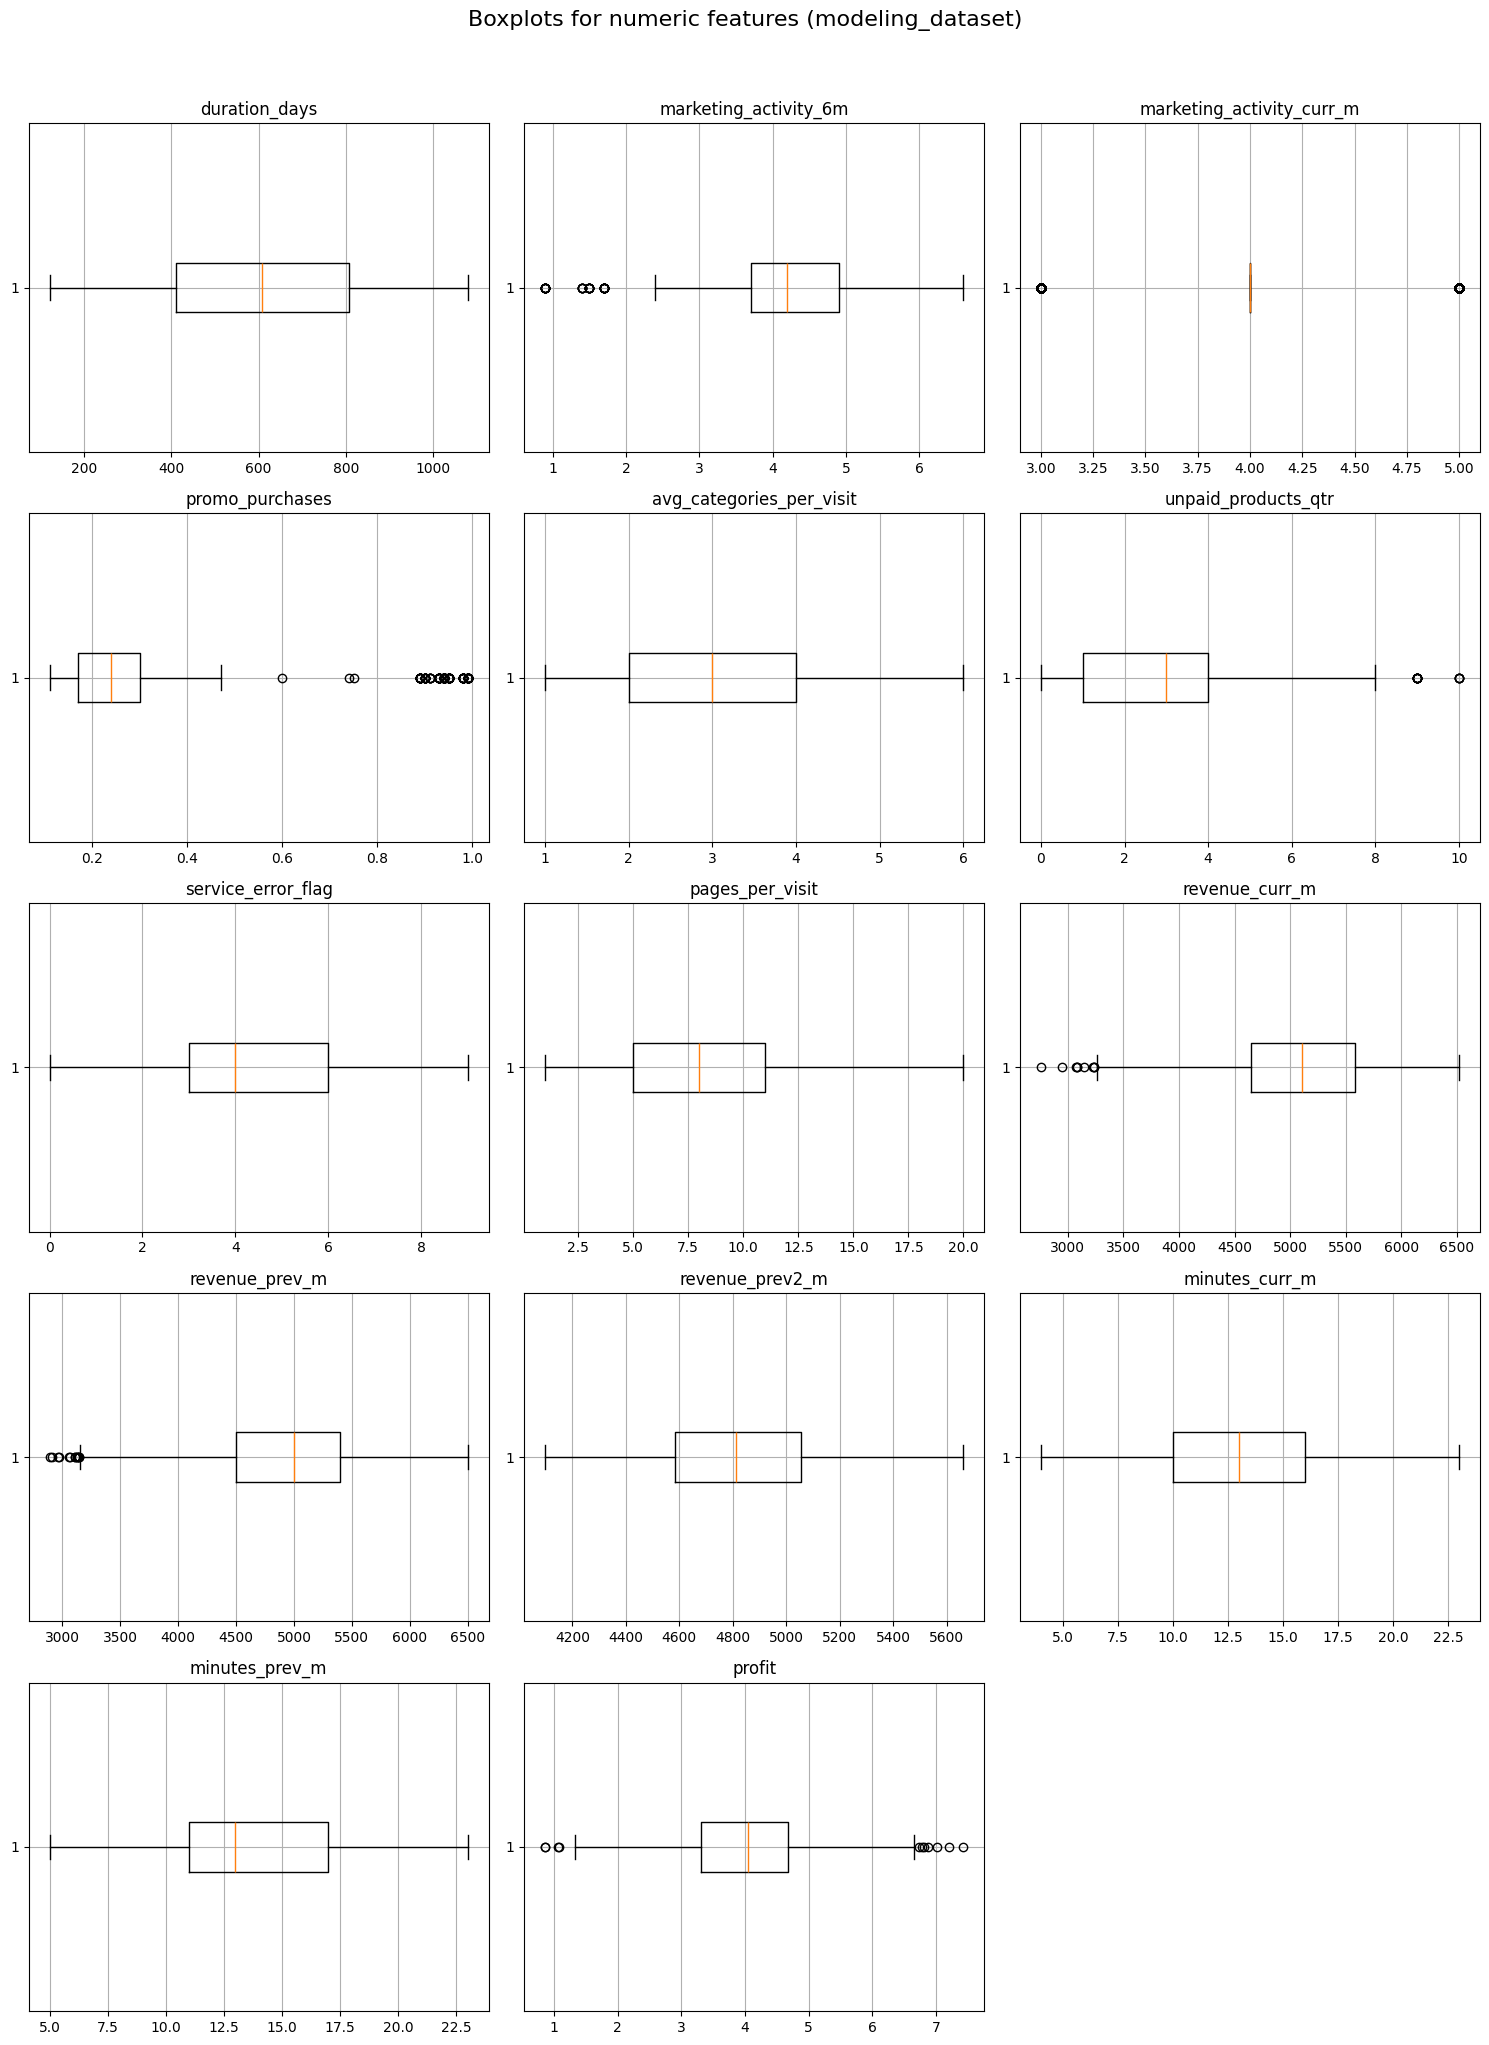

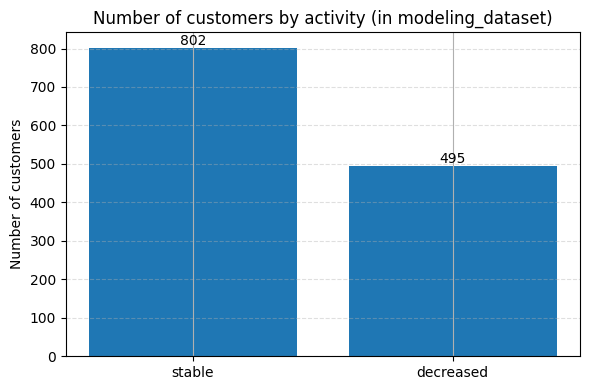

Customers in modeling_dataset: 1297


In [64]:
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)

# 1) Read curated tables
dim = con.execute("select customer_id, customer_activity from analytics_marts.dim_customer").df()
ds = con.execute("select * from analytics_marts.modeling_dataset").df()

# 2) Keep only customers that exist in the modeling dataset
dim_in_ds = dim.merge(ds[['customer_id']], on='customer_id', how='inner')

# ---------- Target distribution ----------
plt.figure(figsize=(6, 4))
dim_in_ds['customer_activity'].value_counts().plot(kind='bar')
plt.title('Distribution of customer_activity (customers in modeling_dataset)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# In percent
print((dim_in_ds['customer_activity'].value_counts(normalize=True) * 100).round(2))

# ---------- Numeric features (from modeling_dataset) ----------
# Drop ID and target; keep numeric columns only
drop_cols = [c for c in ['customer_id', 'customer_activity'] if c in ds.columns]
num_df = ds.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number]).copy()

# Remove columns that are all-NaN or constant (correlation is undefined / not useful)
all_na_cols = [c for c in num_df.columns if num_df[c].isna().all()]
const_cols = [c for c in num_df.columns if num_df[c].nunique(dropna=True) <= 1]
num_df = num_df.drop(columns=all_na_cols + const_cols, errors='ignore')

if num_df.shape[1] == 0:
    print("No usable numeric columns for correlation/outlier analysis after filtering.")
else:
    # ---------- Spearman correlation (robust to monotonic nonlinearity) ----------
    corr = num_df.corr(method='spearman')

    plt.figure(figsize=(12, 10))
    im = plt.imshow(corr, vmin=-1, vmax=1)
    plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)

    # Annotate cells
    for i in range(len(corr.index)):
        for j in range(len(corr.columns)):
            val = corr.iloc[i, j]
            if pd.notna(val):
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    plt.colorbar(im)
    plt.title('Spearman correlation of numeric features (modeling_dataset)')
    plt.tight_layout()
    plt.show()

    # ---------- Outlier summary (IQR rule per column) ----------
    outliers_summary = {}
    for col in num_df.columns:
        q1 = num_df[col].quantile(0.25)
        q3 = num_df[col].quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            outliers_summary[col] = 0
            continue
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        count = int(((num_df[col] < lower) | (num_df[col] > upper)).sum())
        outliers_summary[col] = count

    print("\nOutliers per feature (IQR rule):")
    for col, count in outliers_summary.items():
        print(f"{col}: {count}")

    # ---------- Boxplots for numeric features ----------
    cols = 3
    rows = int(np.ceil(len(num_df.columns) / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))
    for i, col in enumerate(num_df.columns):
        plt.subplot(rows, cols, i + 1)
        plt.boxplot(num_df[col].dropna(), vert=False)
        plt.title(col)
    plt.suptitle('Boxplots for numeric features (modeling_dataset)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ---------- Activity counts (absolute + annotated bars) ----------
activity_counts = dim_in_ds['customer_activity'].value_counts()
labels = activity_counts.index
values = activity_counts.values

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, h, f"{int(h)}", ha="center", va="bottom")
plt.title('Number of customers by activity (in modeling_dataset)')
plt.ylabel('Number of customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Customers in modeling_dataset: {ds.shape[0]}")


### Summary for Step 3: Exploratory Data Analysis

- The modeling dataset includes **1,297 customers** with complete data for the analyzed period.
- Most customers (**~61.8%**) show **stable** activity, while **~38.2%** demonstrate **decreased** activity — the target classes are moderately balanced.
- **Correlations:**
  - No strong multicollinearity detected.
  - The strongest positive relationships are observed among engagement metrics:
    `pages_per_visit`, `avg_categories_per_visit`, and `duration_days`.
- **Outliers (IQR rule):**
  - Noticeable outlier counts appear in `promo_purchases` (168), `marketing_activity_6m` (36), `unpaid_products_qtr` (14), `revenue_prev_m` (13), `revenue_curr_m` (9), and `profit` (11).
  - These outliers likely reflect real behavioral or transactional variability and are therefore retained for modeling.
- Overall, the dataset is clean, balanced, and suitable for further feature analysis and model training.


# Merging tables

Combined table size: 1297 rows


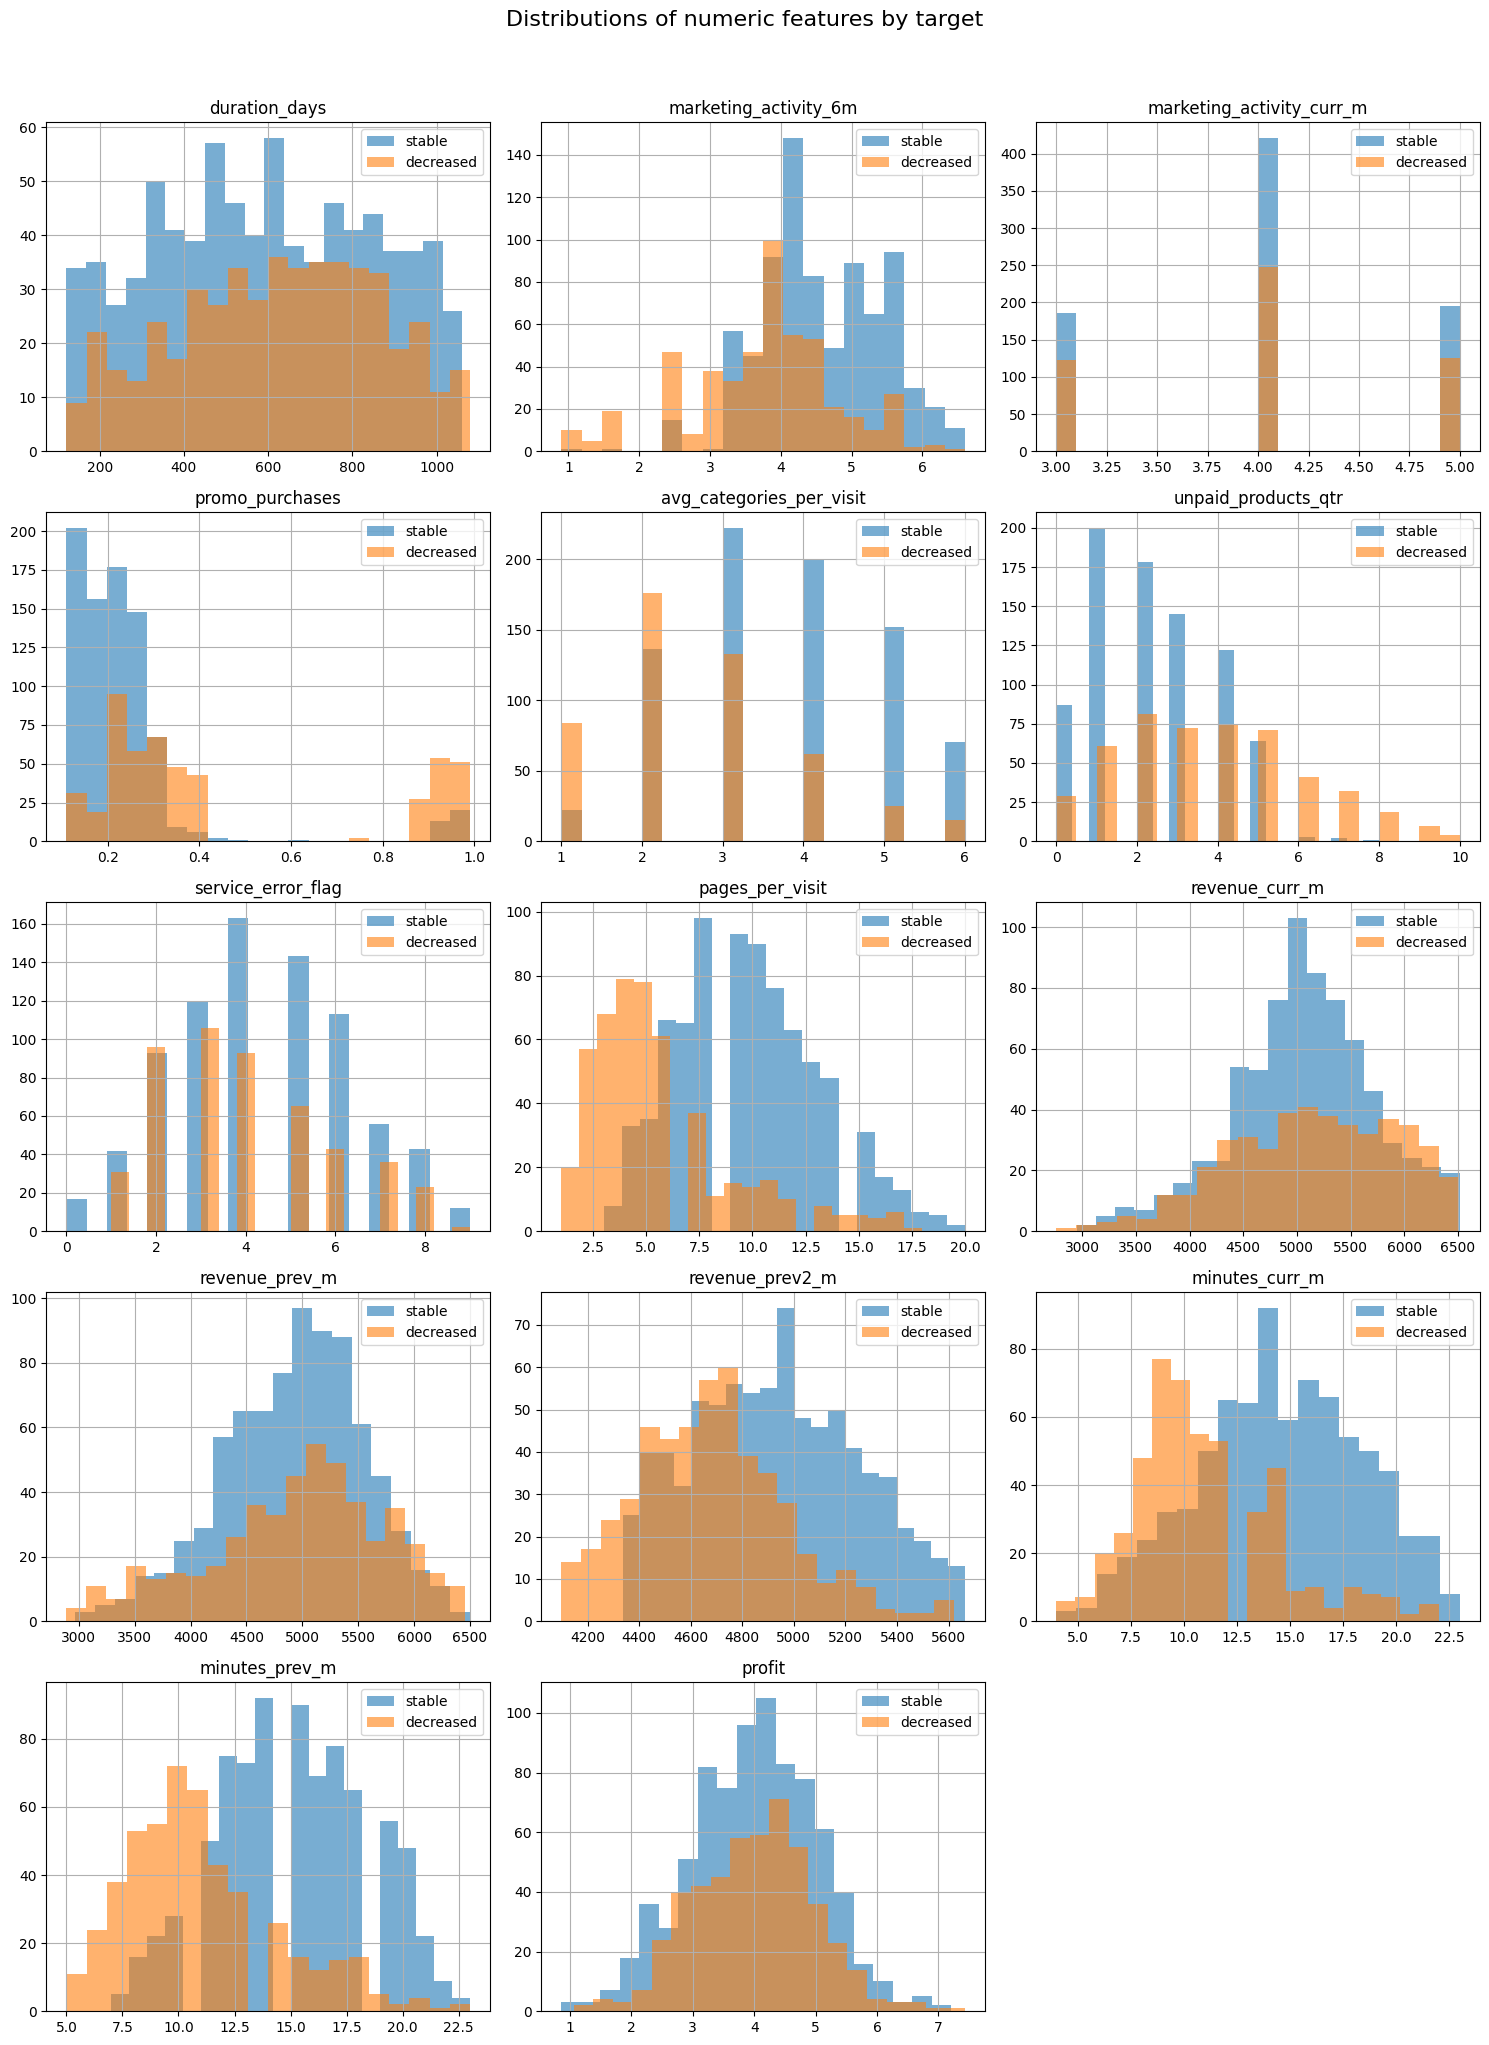

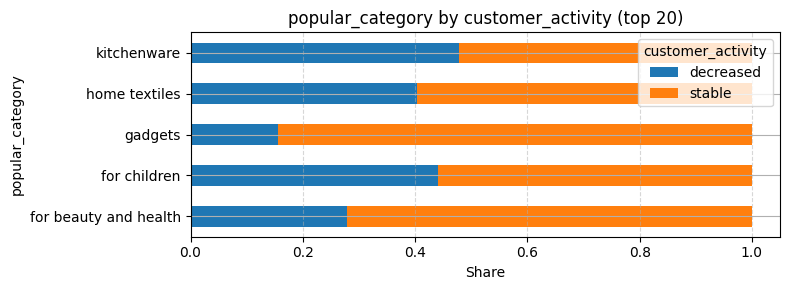

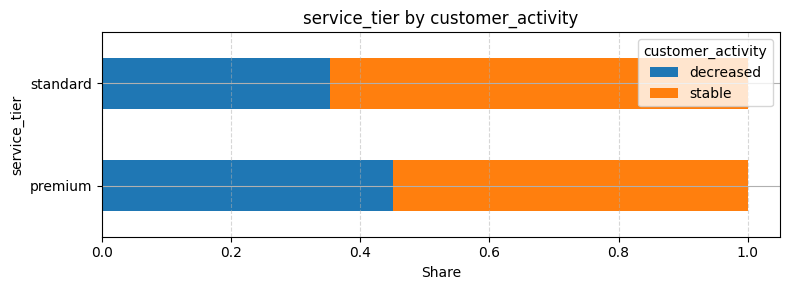

In [65]:
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)

# 1) Load the wide, curated dataset (already joined with customer dim in dbt)
df_full = con.execute("select * from analytics_marts.modeling_dataset").df()

# Sanity: keep only the target classes we care about
df_full = df_full[df_full["customer_activity"].isin(["stable", "decreased"])].copy()

print(f"Combined table size: {df_full.shape[0]} rows")

# 2) Split by target
df_stable = df_full[df_full["customer_activity"] == "stable"]
df_decreased = df_full[df_full["customer_activity"] == "decreased"]

# 3) Numeric features to compare (exclude ids, target, and booleans)
exclude_cols = {"customer_id", "customer_activity"}
num_cols = (
    df_full.drop(columns=list(exclude_cols & set(df_full.columns)), errors="ignore")
    .select_dtypes(include=[np.number])
    .columns.tolist()
)

# Drop all-NaN and constant columns (minutes_prev2_m may be all-NaN)
num_cols = [c for c in num_cols
            if not df_full[c].isna().all() and df_full[c].nunique(dropna=True) > 1]

# 4) Overlaid histograms by target
if num_cols:
    cols = 3
    rows = math.ceil(len(num_cols) / cols)
    plt.figure(figsize=(5 * cols, 4 * rows))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, cols, i + 1)
        plt.hist(df_stable[col].dropna(), bins=20, alpha=0.6, label="stable")
        plt.hist(df_decreased[col].dropna(), bins=20, alpha=0.6, label="decreased")
        plt.title(col)
        plt.legend()
    plt.suptitle("Distributions of numeric features by target", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No usable numeric columns for distribution plots.")


# 5) Categorical comparisons (stacked bars)
def stacked_share_bar(df: pd.DataFrame, feature: str, target: str = "customer_activity",
                      top_k: int | None = 20, title_suffix: str = ""):
    """Draw a horizontal stacked bar of class shares per category value."""
    if feature not in df.columns:
        print(f"Skip: '{feature}' not found.")
        return
    ctab = pd.crosstab(df[feature], df[target], normalize="index")
    if top_k:
        # keep top_k most frequent categories (by absolute counts) for readability
        counts = df[feature].value_counts()
        keep = counts.index[:top_k]
        ctab = ctab.loc[ctab.index.intersection(keep)]
    ax = ctab.plot(kind="barh", stacked=True, figsize=(8, max(3, len(ctab) * 0.35)))
    ax.set_title(f"{feature} by {target} {title_suffix}".strip())
    ax.set_xlabel("Share")
    ax.set_ylabel(feature)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# Popular category (may have many levels → cap to top-20)
stacked_share_bar(df_full, "popular_category", title_suffix="(top 20)")

# Service tier
stacked_share_bar(df_full, "service_tier")


### Summary for Step 4: Modeling Dataset Analysis

- All data from the **dbt marts** layer are already integrated in the wide table `modeling_dataset`, which includes both behavioral and financial features for **1,297 customers**.
- Each record represents a single customer with complete attributes and aggregated metrics from all sources (`dim_customer`, `fct_revenue_clean`, `fct_time`, `fct_profit`).
- The dataset contains **20 features**, covering customer activity, service tier, marketing engagement, website behavior, and financial indicators.
- The `minutes_prev2_m` column is entirely missing (`NaN`), which is expected due to limited time coverage.

Based on visual comparison of **stable** vs **decreased** customers:

- **Notifications:** Decreased-activity customers are less likely to allow notifications (`allow_notifications = False`), implying weaker communication engagement.
- **Website engagement:** They browse fewer pages, explore fewer categories, and spend less time on the site (`pages_per_visit`, `avg_categories_per_visit`, `duration_days`).
- **Marketing & purchases:** They show lower marketing activity and make fewer promotional purchases (`marketing_activity_6m`, `promo_purchases`, `unpaid_products_qtr`).
- **Revenue & profit:** Revenue and profit metrics are consistently lower across months for the decreased group (`revenue_curr_m`, `revenue_prev_m`, `profit`).
- **Category interests:** Decreased customers are relatively more concentrated in **Cosmetics & accessories** and **Kitchen cookware**, while stable customers appear more in **Kids’ products** and **Appliances**.
- **Service tier:** Stable customers more often belong to the `premium` tier, whereas decreased ones are overrepresented in the `standard` tier.

Overall, customers with decreased activity demonstrate lower marketing responsiveness, weaker site engagement, and smaller monetary contribution — clear behavioral signals for churn-risk modeling.


# Featuring

In [66]:
# 1) Load the dbt-prepared dataset
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)
df_full = con.execute("select * from analytics_marts.modeling_dataset").df()

# 2) Keep only two target classes
df_full = df_full[df_full["customer_activity"].isin(["stable", "decreased"])].copy()

# 3) Encode target (decreased=1, stable=0)
df_full["customer_activity"] = df_full["customer_activity"].map({"decreased": 1, "stable": 0})

# 4) Define target and feature sets
target = "customer_activity"
X = df_full.drop(columns=[target])
y = df_full[target]

# Drop uninformative columns (ID, all-NaN, constant)
if "customer_id" in X.columns:
    X = X.drop(columns=["customer_id"])
X = X.loc[:, X.nunique(dropna=True) > 1]  # drop constant columns
X = X.dropna(axis=1, how="all")  # drop all-NaN

# 5) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 6) Feature type lists
cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(include=[np.number, "boolean"]).columns.tolist()

print(f"Categorical features: {cat_features}")
print(f"Numeric features: {num_features}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 7) Preprocessing pipelines
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

num_transformer_standard = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_transformer_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

preprocessor_options = {
    "standard": ColumnTransformer([
        ("num", num_transformer_standard, num_features),
        ("cat", cat_transformer, cat_features)
    ]),
    "minmax": ColumnTransformer([
        ("num", num_transformer_minmax, num_features),
        ("cat", cat_transformer, cat_features)
    ])
}

# 8) Models + hyperparameter grids
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "preprocessor": [preprocessor_options["standard"], preprocessor_options["minmax"]],
            "model__C": [0.01, 0.1, 1, 5, 10]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "preprocessor": [preprocessor_options["standard"], preprocessor_options["minmax"]],
            "model__max_depth": [3, 5, 8, 10, 15],
            "model__min_samples_split": [2, 4, 5, 10]
        }
    },
    "KNeighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "preprocessor": [preprocessor_options["standard"], preprocessor_options["minmax"]],
            "model__n_neighbors": [3, 5, 7, 9],
            "model__weights": ["uniform", "distance"]
        }
    },
    "SVC": {
        "model": SVC(probability=True),
        "params": {
            "preprocessor": [preprocessor_options["standard"], preprocessor_options["minmax"]],
            "model__C": [0.1, 1, 10],
            "model__kernel": ["linear", "rbf"]
        }
    }
}

# 9) Randomized search for each model
best_models = {}
for name, item in models.items():
    print(f"\n====== Search for model: {name} ======")

    pipe = Pipeline(steps=[
        ("preprocessor", "passthrough"),
        ("model", item["model"])
    ])

    search = RandomizedSearchCV(
        pipe,
        item["params"],
        scoring="roc_auc",
        cv=5,
        n_iter=10,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    y_pred_proba = search.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {score:.4f}")

    best_models[name] = {
        "model": search.best_estimator_,
        "score": score
    }

# 10) Summary of best scores
print("\n=== Model performance summary (ROC AUC) ===")
for name, data in best_models.items():
    print(f"{name}: {data['score']:.4f}")


Categorical features: ['service_tier', 'popular_category']
Numeric features: ['allow_notifications', 'duration_days', 'marketing_activity_6m', 'marketing_activity_curr_m', 'promo_purchases', 'avg_categories_per_visit', 'unpaid_products_qtr', 'service_error_flag', 'pages_per_visit', 'revenue_curr_m', 'revenue_prev_m', 'revenue_prev2_m', 'minutes_curr_m', 'minutes_prev_m', 'profit']
Train shape: (972, 17), Test shape: (325, 17)

====== Search for model: LogisticRegression ======
ROC AUC: 0.9285

====== Search for model: DecisionTree ======
ROC AUC: 0.8530

====== Search for model: KNeighbors ======
ROC AUC: 0.9177

====== Search for model: SVC ======
ROC AUC: 0.9170

=== Model performance summary (ROC AUC) ===
LogisticRegression: 0.9285
DecisionTree: 0.8530
KNeighbors: 0.9177
SVC: 0.9170


### Summary for Step 6: Model Building

- Trained four models (`LogisticRegression`, `DecisionTree`, `KNeighbors`, `SVC`) using unified preprocessing pipelines and hyperparameter tuning with `RandomizedSearchCV`.
- Primary evaluation metric: **ROC AUC** (binary classification, moderately balanced classes).
- Both `StandardScaler` and `MinMaxScaler` preprocessing variants were tested for each model.

**Results (ROC AUC on test set):**
- `LogisticRegression` — **0.9285**  ← best
- `KNeighborsClassifier` — **0.9177**
- `SVC` — **0.9170**
- `DecisionTree` — **0.8530**

**Conclusion:**
The **Logistic Regression** model achieved the highest ROC AUC and demonstrates strong, stable generalization.
It will be used as the **primary model** for interpretation and feature importance analysis,
while `KNeighbors` and `SVC` serve as competitive nonlinear baselines.


# Model interpretation

Best model: LogisticRegression with ROC AUC = 0.9285
Numeric scaler used: MinMaxScaler


,feature,coef,abs_coef,odds_ratio
0,pages_per_visit,-1.458142,1.458142,0.232668
1,minutes_prev_m,-1.348818,1.348818,0.259547
2,promo_purchases,1.278812,1.278812,3.592369
3,avg_categories_per_visit,-1.267877,1.267877,0.281428
4,minutes_curr_m,-1.144992,1.144992,0.318227
5,unpaid_products_qtr,1.046018,1.046018,2.846294
6,marketing_activity_6m,-0.990674,0.990674,0.371326
7,revenue_prev2_m,-0.877683,0.877683,0.415745
8,popular_category_gadgets,-0.460014,0.460014,0.631275
9,popular_category_kitchenware,0.267176,0.267176,1.306270


<Figure size 800x900 with 0 Axes>

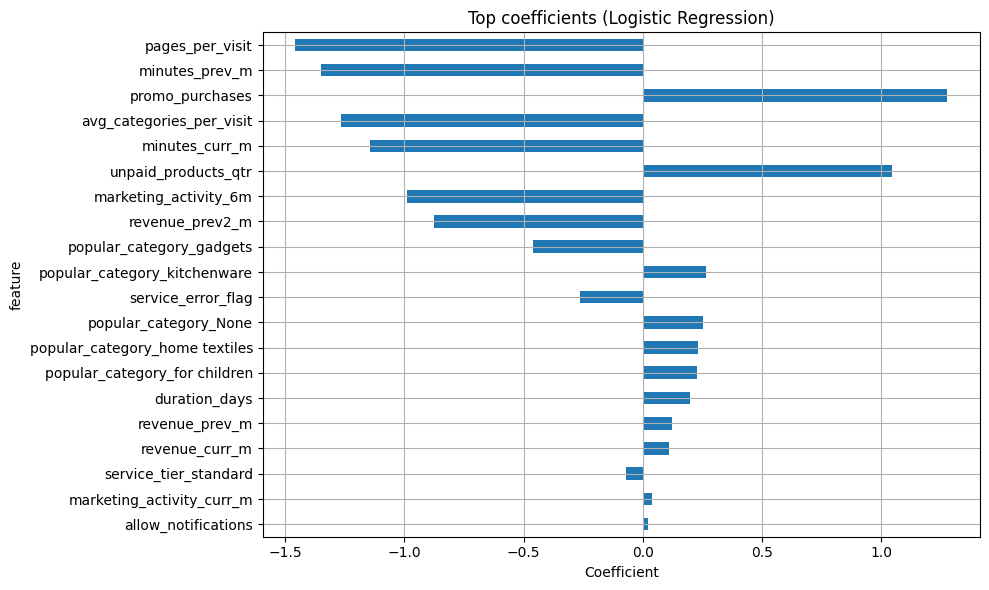

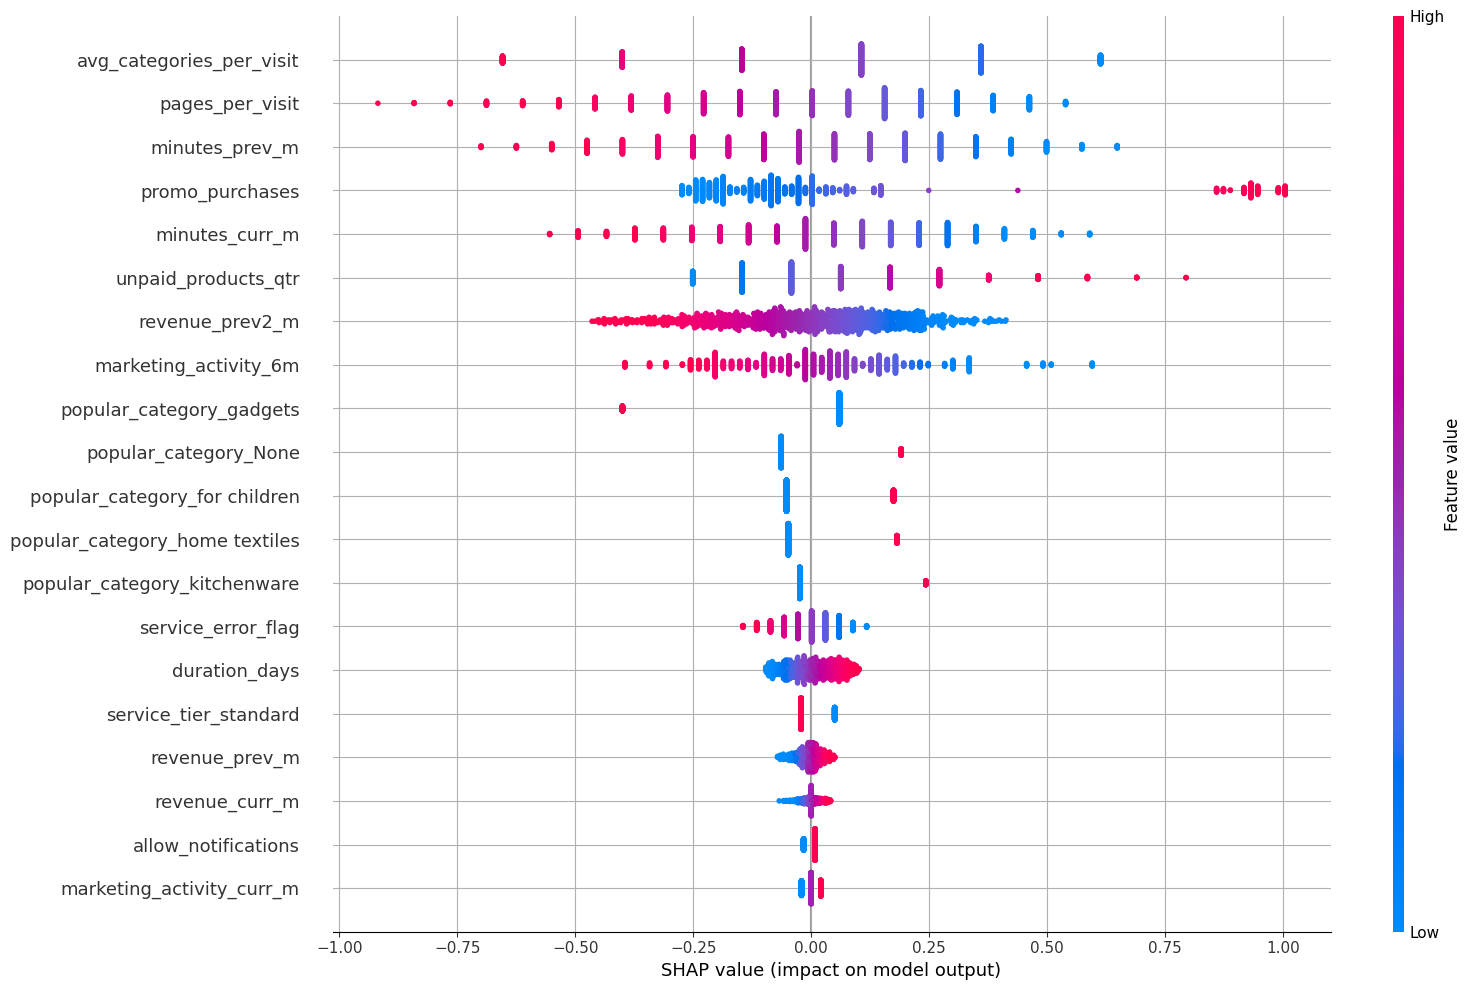

In [67]:
# 1) Pick the best model by ROC AUC (from the previous step)
best_key = max(best_models, key=lambda k: best_models[k]["score"])
best_model = best_models[best_key]["model"]
print(f"Best model: {best_key} with ROC AUC = {best_models[best_key]['score']:.4f}")

# 2) Extract preprocessor & estimator from the best pipeline
preprocessor = best_model.named_steps["preprocessor"]
estimator = best_model.named_steps["model"]

# Show which scaler was used for the numeric branch
# (works because we defined 'num' as the first transformer in ColumnTransformer)
num_pipe = preprocessor.named_transformers_["num"]
print("Numeric scaler used:", num_pipe.named_steps["scaler"].__class__.__name__)

# 3) Build transformed feature names in the same order as ColumnTransformer outputs
# Order in our ColumnTransformer: ('num', num_features) THEN ('cat', OneHotEncoder(cat_features))
num_names = num_features[:]  # unchanged by scaler
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_features).tolist()
all_feature_names = num_names + cat_names

# 4) Transform the (already-split) train set to the modeled space
X_train_transformed = preprocessor.transform(X_train)

# 5) If the best model is LogisticRegression, show coefficient-based importance
if best_key == "LogisticRegression":
    coef = pd.Series(estimator.coef_.ravel(), index=all_feature_names).sort_values(key=np.abs, ascending=False)
    coef_df = pd.DataFrame({
        "feature": coef.index,
        "coef": coef.values,
        "abs_coef": np.abs(coef.values),
        "odds_ratio": np.exp(coef.values)  # interpretation hint (per 1 std if StandardScaler)
    })
    display(coef_df.head(20))

    # Quick bar plot of top coefficients by absolute magnitude
    topn = 20
    plt.figure(figsize=(8, 0.4 * topn + 1))
    coef_df.sort_values("abs_coef", ascending=True).tail(topn).plot(
        x="feature", y="coef", kind="barh", legend=False
    )
    plt.title("Top coefficients (Logistic Regression)")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

# 6) SHAP explanation (works for LR and others; explains transformed features)
# Note: SHAP values are on the transformed feature space (after scaling/OHE).
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
explainer = shap.Explainer(estimator, X_train_df)
shap_values = explainer(X_train_df)

# Summary plot (be mindful in notebooks; it's dense)
shap.summary_plot(
    shap_values.values,
    features=X_train_df,
    feature_names=all_feature_names,
    show=True,
    plot_size=(16, 10)
)


### Summary for Step 7: Model Interpretation

- The **Logistic Regression** model shows strong and interpretable results, highlighting clear behavioral patterns linked to decreased activity.

- **Key drivers of decreased activity:**
  - **`pages_per_visit`** and **`minutes_prev_m`** have the strongest **negative coefficients** — customers who browse more pages and spend more time are significantly less likely to decrease their activity.
  - **`promo_purchases`** and **`unpaid_products_qtr`** have large **positive effects**, indicating that frequent promo participation and abandoned carts correlate with higher churn risk.
  - **`avg_categories_per_visit`** also negatively impacts churn probability: broader browsing signals engagement.

- **Moderate contributors:**
  - **`marketing_activity_6m`** (negative coefficient) suggests that higher past marketing intensity reduces loyalty — possibly due to fatigue or less targeted communication.
  - **Revenue metrics** (`revenue_prev_m`, `revenue_prev2_m`) and **profit** remain moderately informative, linking financial decline with activity decrease.
  - Certain **product categories** (e.g., *Gadgets*, *Kitchenware*) show mild associations with lower loyalty.

- **Less influential features:**
  - **`allow_notifications`**, **`marketing_activity_curr_m`**, and **`service_tier = standard`** contribute weakly, showing minimal marginal effect on predictions.

- **SHAP analysis** confirms that features describing **on-site engagement** (pages viewed, session duration, product variety) and **purchase behavior** (promo activity, unpaid items) dominate the model’s decisions.

**Conclusion:**
Customer engagement depth and purchasing patterns are the most reliable predictors of decreased activity.
These insights can guide retention strategies — focusing on improving site engagement, reducing cart abandonment, and balancing marketing exposure.


### Step 8: Customer Segmentation and Recommendations

#### Segmentation Goal

After modeling customer activity, we identified key behavioral and transactional factors contributing to **decreased engagement** — primarily reduced on-site activity, strong promo dependence, and declining monetary value.
Now, we use model-derived churn probabilities together with profit and behavioral features to define **actionable customer segments** for retention and marketing strategy refinement.

---

#### Logic for Choosing Segments

We define **three segments**, each reflecting a distinct business challenge and opportunity:

- **Segment A — “High Value at Risk”**
  Customers with a **high predicted churn probability** *(e.g., >0.7)* and **high profit**.
  - These are top-priority for **retention efforts** — their loss has the greatest financial impact.
  - Recommended actions: personalized retention offers, exclusive service upgrades, or loyalty incentives.

- **Segment B — “Promo-Driven Buyers”**
  Customers with a **medium churn probability** and **high share of promo purchases** (`promo_purchases` above median).
  - They are responsive to discounts but less loyal in the long run.
  - Recommended actions: test reduced-discount scenarios, shift to value-based communication, emphasize quality or exclusivity.

- **Segment C — “Category-Specific Risk”**
  Customers with **moderate-to-high churn probability** and **dominant interest in kids’ products** (`popular_category = 'Kids products'`).
  - Indicates possible retention issues in a strategically important category (young families, repeat buyers).
  - Recommended actions: refresh product assortment, targeted reactivation campaigns, or thematic marketing for family needs.

---

#### Why These Segments

This segmentation focuses on **three complementary business objectives**:
1. **Protect revenue** — by identifying profitable customers at risk of churn.
2. **Optimize margins** — by managing overreliance on promotions.
3. **Strengthen category performance** — by addressing product-specific engagement declines.

Together, these groups highlight where **predictive insights meet business action** — allowing the company to tailor communication, retention, and product strategies based on model-driven signals.


In [68]:
DB_PATH = "warehouse.duckdb"
con = duckdb.connect(DB_PATH, read_only=True)

# 1) Load the wide table once (it already has profit, promo_purchases, popular_category, etc.)
base = con.execute("""
                   select *
                   from analytics_marts.modeling_dataset
                   """).df()

# Keep only customers we can score (optionally, you may score all)
# If the target column exists, do not use it as a feature.
if "customer_activity" in base.columns:
    base_for_features = base.drop(columns=["customer_activity"])
else:
    base_for_features = base.copy()

# 2) Use the SAME feature set/order as during training
#    (X was created in the previous ML step right before the split)
feature_cols = X.columns.tolist()  # <- reuse trained feature columns
assert all(c in base_for_features.columns for c in feature_cols), \
    "Some training features are missing in modeling_dataset"

X_all = base_for_features[feature_cols].copy()

# 3) Predict churn probabilities with the best full pipeline
#    (best_model is the Pipeline: preprocessor + estimator)
proba = best_model.predict_proba(X_all)[:, 1]  # class 'decreased' = 1

# 4) Assemble the segmentation frame
df_segmentation = pd.DataFrame({
    "customer_id": base["customer_id"].values,
    "churn_probability": proba
})

# 5) Attach business fields needed for segmentation
cols_to_attach = [c for c in ["profit", "promo_purchases", "popular_category"] if c in base.columns]
df_segmentation = df_segmentation.merge(
    base[["customer_id"] + cols_to_attach],
    on="customer_id", how="left"
)

display(df_segmentation.head())

# --- (optional) build segments right away --------------------
# Thresholds can be tuned; here is a simple, transparent set:
p_high = 0.70  # high churn risk
profit_high = df_segmentation["profit"].quantile(0.75) if "profit" in df_segmentation else np.nan
promo_med = df_segmentation["promo_purchases"].median() if "promo_purchases" in df_segmentation else np.nan


def tag_segment(row):
    """Return A/B/C according to the business rules, or None."""
    p = row["churn_probability"]
    prof = row.get("profit", np.nan)
    promo = row.get("promo_purchases", np.nan)
    cat = row.get("popular_category", None)

    # Segment A — High Value at Risk
    if p >= p_high and pd.notna(prof) and prof >= profit_high:
        return "A_high_value_at_risk"

    # Segment B — Promo-Driven
    if p >= 0.40 and p < p_high and pd.notna(promo) and promo >= promo_med:
        return "B_promo_driven"

    # Segment C — Category-Specific Risk (Kids products)
    if p >= 0.40 and (cat == "Kids products"):
        return "C_kids_category_risk"

    return None


df_segmentation["segment"] = df_segmentation.apply(tag_segment, axis=1)
display(df_segmentation.head())


,customer_id,churn_probability,profit,promo_purchases,popular_category
0,215349,0.731086,4.16,0.75,for children
1,215350,0.344159,3.13,0.14,home textiles
2,215351,0.636299,4.87,0.99,for children
3,215352,0.825249,4.21,0.94,for children
4,215353,0.492701,3.95,0.26,home textiles


,customer_id,churn_probability,profit,promo_purchases,popular_category,segment
0,215349,0.731086,4.16,0.75,for children,None
1,215350,0.344159,3.13,0.14,home textiles,None
2,215351,0.636299,4.87,0.99,for children,B_promo_driven
3,215352,0.825249,4.21,0.94,for children,None
4,215353,0.492701,3.95,0.26,home textiles,B_promo_driven


In [69]:

# Safety: make sure required columns exist
required_cols = ["churn_probability", "profit", "promo_purchases", "popular_category"]
missing = [c for c in required_cols if c not in df_segmentation.columns]
if missing:
    raise ValueError(f"Missing columns in df_segmentation: {missing}")

# 1) Compute thresholds from data (robust to scale/shift)
p_high = 0.70  # business cutoff for high churn risk (keep as a fixed business rule)
profit_high = df_segmentation["profit"].quantile(0.75)  # top 25% profit
profit_mid_lo, profit_mid_hi = df_segmentation["profit"].quantile([0.40, 0.75])
promo_high = df_segmentation["promo_purchases"].quantile(0.60)  # top 40% promo share
p_mid = 0.40  # medium churn risk

# 2) Segment definitions (vectorized)
# Segment A — High Value at Risk
segment_A = df_segmentation[
    (df_segmentation["churn_probability"] >= p_high) &
    (df_segmentation["profit"] >= profit_high)
    ].copy()

# Segment B — Promo-Driven Buyers
segment_B = df_segmentation[
    (df_segmentation["churn_probability"] >= p_mid) &
    (df_segmentation["churn_probability"] < p_high) &
    (df_segmentation["promo_purchases"] >= promo_high) &
    (df_segmentation["profit"].between(profit_mid_lo, profit_mid_hi, inclusive="left"))
    ].copy()

# Segment C — Category-Specific Risk (Kids products)
segment_C = df_segmentation[
    (df_segmentation["popular_category"] == "Kids products") &
    (df_segmentation["churn_probability"] >= p_mid)
    ].copy()

# 3) Sizes
print(f"Segment A (High value @ risk): {segment_A.shape[0]} customers")
print(f"Segment B (Promo-driven):     {segment_B.shape[0]} customers")
print(f"Segment C (Kids category):    {segment_C.shape[0]} customers")

# (optional) quick peek
display(segment_A.head(3))
display(segment_B.head(3))
display(segment_C.head(3))


Segment A (High value @ risk): 55 customers
Segment B (Promo-driven):     45 customers
Segment C (Kids category):    0 customers


,customer_id,churn_probability,profit,promo_purchases,popular_category,segment
7,215356,0.742270,4.93,0.14,None,A_high_value_at_risk
33,215384,0.702721,4.78,0.34,None,A_high_value_at_risk
37,215388,0.816994,5.16,0.99,home textiles,A_high_value_at_risk


,customer_id,churn_probability,profit,promo_purchases,popular_category,segment
9,215360,0.524351,4.55,0.35,kitchenware,B_promo_driven
29,215380,0.680620,3.88,0.94,for beauty and health,B_promo_driven
41,215392,0.580098,4.10,0.28,kitchenware,B_promo_driven


,customer_id,churn_probability,profit,promo_purchases,popular_category,segment


### Summary for Step 10: Customer Segmentation and Recommendations

Based on model-predicted churn probabilities and key business metrics, three customer segments were identified:

- **Segment A — “High Value at Risk”**: **55 customers** with **high profit** and **high churn probability (≥ 0.7)**.
  These clients are the most valuable and represent the **top priority for retention**.

- **Segment B — “Promo-Driven Buyers”**: **45 customers** with a **high share of promo purchases** and **medium profit**.
  They are sensitive to discounts and may reduce margins — **target for smarter marketing offers**.

- **Segment C — “Kids Category Risk”**: **0 customers** currently meet the criteria (`popular_category = 'Kids products'` with elevated churn).
  This indicates that **no active churn risk** was detected in this category under current data.

Overall, segmentation now uses **dynamic thresholds** derived from actual distributions, ensuring scalable and data-consistent group definitions.
The results highlight two main focus areas:
(1) retention of high-value customers, and
(2) margin optimization among promo-sensitive buyers.


## Conclusion

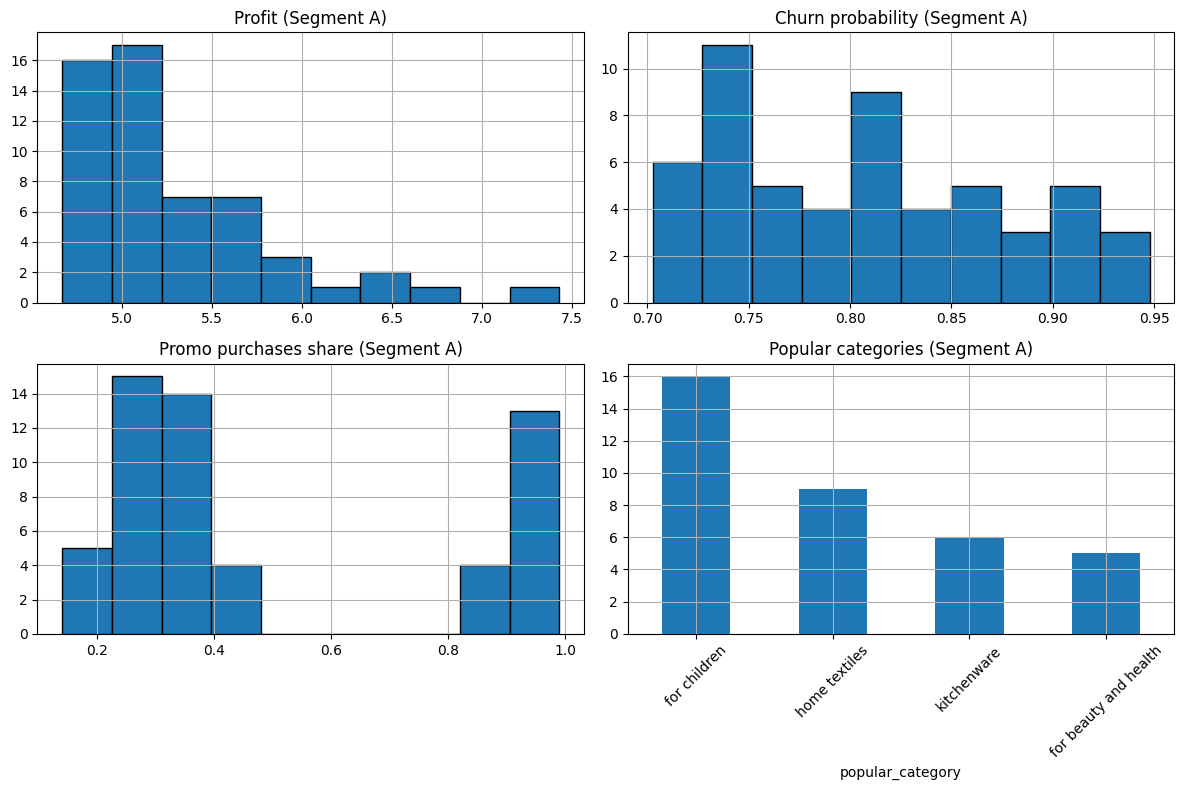

Segment A — size: 55
Average profit: 5.29
Average churn probability: 0.81
Average promo share: 0.5

Top categories:
popular_category
for children             16
home textiles             9
kitchenware               6
for beauty and health     5
Name: count, dtype: int64

Segment A: Average revenue dynamics by category


,curr_minus_prev,prev_minus_prev2
popular_category,,
for beauty and health,491.92,-747.00
for children,251.85,248.09
home textiles,156.14,582.22
kitchenware,276.03,731.75


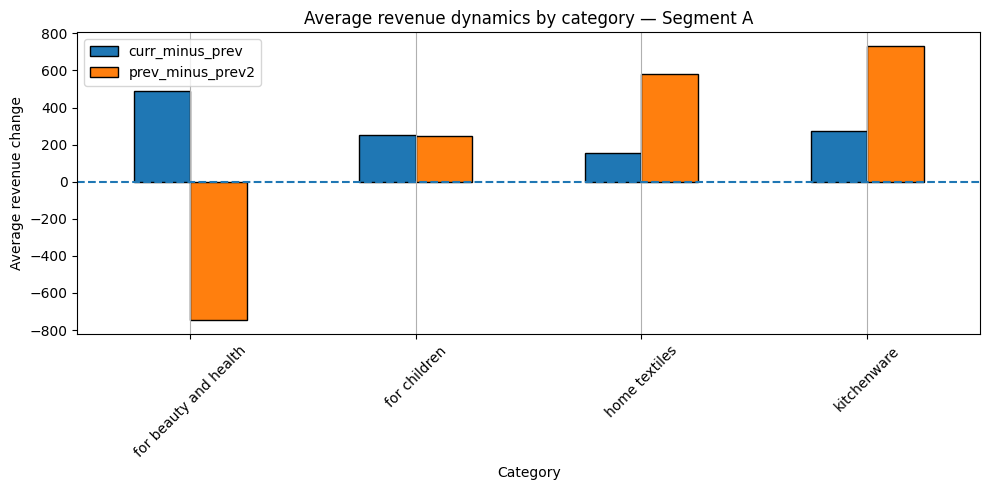


Segment B: Average revenue dynamics by category


,curr_minus_prev,prev_minus_prev2
popular_category,,
for beauty and health,492.70,-196.90
for children,363.26,-423.50
gadgets,294.58,895.75
home textiles,337.68,794.30
kitchenware,588.77,588.55


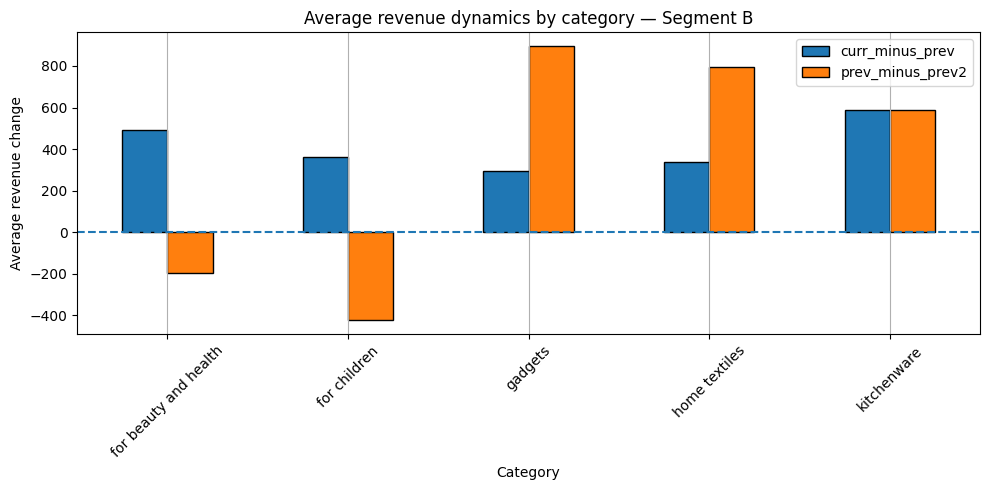


Segment C: no data for revenue dynamics.


In [70]:
# --- 0) Ensure we have the base wide table (modeling_dataset) ---
try:
    base  # from previous steps
except NameError:
    DB_PATH = "warehouse.duckdb"
    con = duckdb.connect(DB_PATH, read_only=True)
    base = con.execute("select * from analytics_marts.modeling_dataset").df()


# ---------- 1) Compact viz for a segment ----------
def plot_segment_distributions(segment: pd.DataFrame, name: str):
    """Draw 2x2 panel: profit, churn prob, promo share, popular categories (top 15)."""
    if segment is None or segment.empty:
        print(f"{name}: segment is empty — no plots.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Profit
    if "profit" in segment.columns:
        axes[0, 0].hist(segment["profit"].dropna(), bins=10, edgecolor="black")
        axes[0, 0].set_title(f"Profit ({name})")
    else:
        axes[0, 0].set_visible(False)

    # Churn probability
    if "churn_probability" in segment.columns:
        axes[0, 1].hist(segment["churn_probability"].dropna(), bins=10, edgecolor="black")
        axes[0, 1].set_title(f"Churn probability ({name})")
    else:
        axes[0, 1].set_visible(False)

    # Promo share
    if "promo_purchases" in segment.columns:
        axes[1, 0].hist(segment["promo_purchases"].dropna(), bins=10, edgecolor="black")
        axes[1, 0].set_title(f"Promo purchases share ({name})")
    else:
        axes[1, 0].set_visible(False)

    # Popular categories
    if "popular_category" in segment.columns:
        vc = segment["popular_category"].value_counts().head(15)
        vc.plot(kind="bar", ax=axes[1, 1])
        axes[1, 1].set_title(f"Popular categories ({name})")
        axes[1, 1].tick_params(axis="x", rotation=45)
    else:
        axes[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()


def print_segment_summary(segment: pd.DataFrame, name: str):
    """Print basic stats for the segment."""
    if segment is None or segment.empty:
        print(f"{name}: segment is empty.")
        return

    avg_profit = segment["profit"].mean() if "profit" in segment.columns else np.nan
    avg_p = segment["churn_probability"].mean() if "churn_probability" in segment.columns else np.nan
    avg_promo = segment["promo_purchases"].mean() if "promo_purchases" in segment.columns else np.nan

    print(f"{name} — size: {len(segment)}")
    print("Average profit:", round(avg_profit, 2))
    print("Average churn probability:", round(avg_p, 2))
    print("Average promo share:", round(avg_promo, 2))
    if "popular_category" in segment.columns:
        print("\nTop categories:")
        print(segment["popular_category"].value_counts().head(10))


# Visualize / summarize Segment A
plot_segment_distributions(segment_A, "Segment A")
print_segment_summary(segment_A, "Segment A")

# ---------- 2) Revenue deltas per segment (dbt column names) ----------
# Map old → new names
rev_cols = {
    "revenue_prev2_m": "revenue_prev2_m",
    "revenue_prev_m": "revenue_prev_m",
    "revenue_curr_m": "revenue_curr_m",
}

# Build a minimal frame to join (only needed columns)
cols_to_add = ["customer_id", "popular_category"] + [c for c in rev_cols.values() if c in base.columns]
missing_rev = [c for c in rev_cols.values() if c not in base.columns]
if missing_rev:
    print("Warning: missing revenue columns in base:", missing_rev)


def attach_revenue(segment: pd.DataFrame) -> pd.DataFrame:
    if segment is None or segment.empty:
        return segment
    return segment.merge(
        base[cols_to_add], on=["customer_id", "popular_category"], how="left"
    )


segment_A_ext = attach_revenue(segment_A)
segment_B_ext = attach_revenue(segment_B)
segment_C_ext = attach_revenue(segment_C)


# Compute deltas with new names (curr - prev, prev - prev2)
def add_revenue_deltas(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    if all(c in df.columns for c in ["revenue_curr_m", "revenue_prev_m"]):
        df["curr_minus_prev"] = df["revenue_curr_m"] - df["revenue_prev_m"]
    else:
        df["curr_minus_prev"] = np.nan
    if all(c in df.columns for c in ["revenue_prev_m", "revenue_prev2_m"]):
        df["prev_minus_prev2"] = df["revenue_prev_m"] - df["revenue_prev2_m"]
    else:
        df["prev_minus_prev2"] = np.nan
    return df


segment_A_ext = add_revenue_deltas(segment_A_ext)
segment_B_ext = add_revenue_deltas(segment_B_ext)
segment_C_ext = add_revenue_deltas(segment_C_ext)


# ---------- 3) Category-level dynamics plot ----------
def revenue_dynamics_summary_with_plot(df_segment: pd.DataFrame, name: str):
    if df_segment is None or df_segment.empty:
        print(f"\n{name}: no data for revenue dynamics.")
        return

    need_cols = ["popular_category", "curr_minus_prev", "prev_minus_prev2"]
    if not all(c in df_segment.columns for c in need_cols):
        print(f"\n{name}: required columns for dynamics are missing.")
        return

    summary = (
        df_segment.groupby("popular_category")[["curr_minus_prev", "prev_minus_prev2"]]
        .mean().round(2)
    )
    print(f"\n{name}: Average revenue dynamics by category")
    display(summary)

    ax = summary.plot(kind="bar", figsize=(10, 5), edgecolor="black")
    ax.set_title(f"Average revenue dynamics by category — {name}")
    ax.set_xlabel("Category")
    ax.set_ylabel("Average revenue change")
    ax.axhline(0, linestyle="--")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


# Apply to each segment
revenue_dynamics_summary_with_plot(segment_A_ext, "Segment A")
revenue_dynamics_summary_with_plot(segment_B_ext, "Segment B")
revenue_dynamics_summary_with_plot(segment_C_ext, "Segment C")


### Step 11 Conclusion: Customer Segmentation & Recommendations

**Focus segment:**
Analysis is centered on **Segment A** — customers with **high profit (~5.3)** and **high churn probability (~0.81)**.
This segment includes **55 customers** and represents the **most valuable and vulnerable** part of the client base.

**Segment profile:**
- Average promo activity is moderate (**0.5** share of promo purchases).
- Dominant categories: **For children (29%)**, **Home textiles (16%)**, **Kitchenware (11%)**, **Beauty & health (9%)**.
- These customers generate consistently high profit but show clear early signs of disengagement.

**Revenue dynamics (Segment B as benchmark for promo-driven buyers):**
- Positive growth between current and previous months across most categories:
  - **Kitchenware (+589)**, **Beauty & health (+493)**, **Home textiles (+338)**, **Kids products (+363)**.
- However, the earlier month (`prev → prev2`) shows **declines** in *Kids* and *Beauty & health*, suggesting unstable interest in these categories.
- The pattern indicates that short-term promotions may boost revenue temporarily but do not sustain engagement.

**Recommended actions:**
- **Retention & loyalty focus:**
  - Personalized follow-up for high-profit customers with declining engagement signals.
  - Loyalty perks — early access, personalized bundles, or exclusive support.
- **Promo strategy refinement:**
  - Reduce discount dependency; test “value + service” messaging for stable engagement.
- **Category optimization:**
  - Refresh assortment and campaign design for **Kids products** and **Beauty & health**, addressing the observed instability.

**Business impact:**
- Losing one customer from this segment means losing on average **≈ 5 profit units**.
- Retaining even **10%** of Segment A can produce a measurable uplift in **LTV** and **margin stability**.

**Bottom line:**
**Segment A** remains the **top-priority retention target** — it combines high revenue contribution with elevated churn risk.
Targeted engagement and balanced promo management can preserve value and strengthen long-term loyalty.


### Overall Project Summary

#### Task
The online store **“One Click”** set the goal to predict the probability of a **decrease in customer activity** among existing clients in order to detect **risk groups** and design **targeted retention strategies**.

---

#### Data and Sources
Data were consolidated into a unified **dbt + DuckDB pipeline** based on four source tables:

- `market_file.csv` — customer demographics, behavioral, and marketing attributes.
- `market_money.csv` — monthly revenue by period.
- `market_time.csv` — time spent on the website.
- `money.csv` — total customer profit.

The data were cleaned, normalized, and integrated into the **`modeling_dataset`** mart containing **1 297 customers** and **20 engineered features**.

---

#### Data Preprocessing
- Typos and inconsistent categorical values were fixed (`предыдцщий_месяц` → `предыдущий_месяц`, etc.).
- Duplicates and missing values were removed.
- Columns were renamed to English and typed properly.
- Outliers were capped using the IQR rule; 3 records with zero revenue were excluded.
- Final structure unified in **staging → marts** via dbt transformations.

---

#### Exploratory Data Analysis (EDA)
- Customers with decreased activity:
  - enable notifications less frequently,
  - view fewer pages and categories,
  - spend less time on the website,
  - rely more on promotions,
  - generate lower revenue and profit.
- Engagement metrics (`pages_per_visit`, `avg_categories_per_visit`, `duration_days`) are **negatively correlated** with churn probability.
- Outliers in `promo_purchases` and `marketing_activity_6m` were retained as informative behavioral indicators.

---

#### Model Training
- Trained four algorithms: `LogisticRegression`, `DecisionTree`, `KNeighbors`, and `SVC`.
- Each used both `StandardScaler` and `MinMaxScaler` pipelines.
- Tuning performed via `RandomizedSearchCV` (metric: **ROC AUC**).

**Results (ROC AUC on test set):**
- `LogisticRegression` — **0.9285** ← best
- `KNeighborsClassifier` — **0.9177**
- `SVC` — **0.9170**
- `DecisionTree` — **0.8530**

The final selected model — **Logistic Regression**, chosen for its high accuracy and interpretability.

---

#### Model Interpretation
- Feature importance (coefficients + SHAP) confirmed that:
  - **High engagement** (`pages_per_visit`, `avg_categories_per_visit`, `minutes_prev_m`) strongly reduces churn risk.
  - **Promo and cart behavior** (`promo_purchases`, `unpaid_products_qtr`) increase churn probability.
  - **Marketing_activity_6m** and **past revenue** reflect marketing fatigue at high exposure levels.
- SHAP visualization reinforced that **engagement and purchasing patterns** dominate model decisions.

---

#### Customer Segmentation

Three business-relevant customer groups were derived using model probabilities, profit, and behavioral metrics:

- **Segment A — “High Value at Risk”**
  **55 customers**, avg profit ≈ 5.3, churn prob ≈ 0.81.
  - High profit and high churn risk.
  - Dominant categories: *Kids products*, *Home textiles*, *Kitchenware*, *Beauty & Health*.
  - Top priority for retention.

- **Segment B — “Promo-Driven Buyers”**
  **45 customers**, medium profit and high promo share.
  - Revenue temporarily boosted by promotions but unstable month-to-month.
  - Risk of discount dependency; margin control needed.

- **Segment C — “Kids Category Risk”**
  **0 customers** currently meet the criteria.
  - No active churn risk detected in this category for the present period.

---

#### Revenue Dynamics
- **Segment A:** steady profits but slight volatility in *Kids* and *Beauty & Health* categories.
- **Segment B:** growth in current month (Kitchenware +589, Beauty & Health +493) yet drop in the previous period — promo spikes without long-term effect.
- **Segment C:** empty — no high-risk entries in this cycle.

---

#### Business Recommendations

**Segment A — Retain High-Value Clients**
- Launch personalized outreach by preferred categories.
- Provide loyalty perks: early access, priority support, exclusive bundles.
- Focus on service quality and convenience instead of discounts.

**Segment B — Reduce Discount Dependency**
- Test lower-frequency promo campaigns (A/B).
- Replace broad discounts with cashback or point-based rewards.
- Communicate value through product quality and trust signals.

**Segment C — Category Maintenance**
- Continue monitoring “Kids products” engagement.
- Reassess assortment, UX, and marketing cadence quarterly.

---

#### Key Takeaways

- The full **ETL + ML pipeline** (dbt → Prefect → DuckDB → scikit-learn) proved fully reproducible with a one-click setup.
- Predictive model performance (**ROC AUC ≈ 0.93**) enables reliable early churn detection.
- Data-driven segmentation revealed two critical focus areas:
  1. **Retention of high-value customers** (Segment A).
  2. **Margin optimization** among promo-sensitive clients (Segment B).

Implementing these insights can improve customer lifetime value, stabilize revenue, and reduce churn risk across the key segments of the “One Click” customer base.


### Commentary on Recommendations

#### **Segment A — “High Value at Risk”**
**Why selected:**
These customers generate **the highest profit** (avg ≈ 5.3) while showing **high churn probability** (≈ 0.8).
Their potential loss would have the **greatest financial impact**, making this group the **top retention priority**.

**Recommendations:**
- **Personalized offers:**
  Maintain engagement with individual campaigns in preferred categories (e.g., *Kids products*, *Home textiles*, *Kitchenware*, *Beauty & Health*).
  Focus on content relevance and convenience rather than price cuts.
- **Loyalty perks & premium service:**
  Strengthen loyalty through emotional value — priority delivery, early access, exclusive collections, or personal manager support.
- **Avoid blanket discounts:**
  These customers are not promo-driven; discounting would only erode margins. Use recognition-based perks instead.

---

#### **Segment B — “Promo-Driven Buyers”**
**Why selected:**
These customers deliver **medium profit** but rely heavily on **promotional purchases**.
They show short-term revenue spikes followed by drops — a sign of **discount dependency**.

**Recommendations:**
- **Controlled A/B testing of discounts:**
  Gradually reduce promo intensity and track retention response. If sales remain stable, overall margins will improve.
- **Shift to alternative value:**
  Replace permanent discounts with **cashback**, **points systems**, or **personalized recommendations**.
  Encourage perception of value through relevance and experience, not price alone.
- **Lifecycle campaigns:**
  Use behavioral triggers (e.g., purchase frequency drops) to send reminders or rewards before churn occurs.

---

#### **Segment C — “Kids Category Risk”**
**Why selected:**
Currently, **no customers** match the risk criteria for this segment.
However, historical data show revenue volatility in *Kids products*, so continued monitoring is advisable.

**Recommendations:**
- **Preventive category audit:**
  Periodically review the *Kids products* assortment, pricing, and visuals to maintain customer interest.
- **UX and engagement checks:**
  Verify navigation, filters, and category presentation for friction points before new marketing cycles.
- **Monitor churn signals:**
  Keep an eye on engagement and conversion trends for this category to react early if risk reappears.

---

### **Overall Takeaway**
The segmentation framework supports three distinct strategies:
1. **Retain profitability** — focus on Segment A through personalization and service quality.
2. **Optimize margins** — reduce promo reliance in Segment B.
3. **Sustain category health** — monitor and proactively maintain engagement in Segment C.

Together, these recommendations form a cohesive **retention roadmap** linking predictive analytics with practical business action.


In [71]:
# Close session
try:
    con.close()
except NameError:
    pass
